# CitiBike TSP
**Algorithms Group 50**\
Donal Lowsley-Williams \
Joan La Rosa \
Isaac Lichter \
Weidong Gao 

We will be conducting the traveling salesman problem on New York City citibike data. We will be using each CitiBike station as the nodes in our graph, and represent the edge costs by the average time it takes to bike from one station to another. Edges will only include those rides in the CitiBike data that have actually occurred - in other words, if no ride in the data started at station A and ended at station B, we will not include that edge. This adds to the realism of the problem as it would be unlikely to take that edge anyways. Moreover, we will only have edges from one station to another - not one station to itself, as there are occurences of rides like this in the CitiBike data.

### Imports
Will we be implementing these algorithms by hand, so we just need libraries for data loading and export, matrix manipulation functions, and some data exploration. 

In [1]:
import csv
import json
import numpy as np
import pandas as pd
import time
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

# The Data
We will get the data from CitiBike's openly available [System Data](https://s3.amazonaws.com/tripdata/index.html). The data we are using was the most recent as of this notebook's creation date, and was published by CitiBike on [**Oct 4th 2021, 01:26:29 pm**](https://s3.amazonaws.com/tripdata/202109-citibike-tripdata.csv.zip). This is the data of all rides taken on the CitiBike system during the month of September 2021. However, the preprocessing should work for any selection of the data from the system data, since they all should follow the same structure. 

Please store the data in a folder named **"Data"** with the name **"citibike-data.csv"**, like so: **"Data/citibike-data.csv**

In [2]:
df = pd.read_csv('Data/citibike-data.csv',
                 parse_dates=['started_at','ended_at'])

/Users/wdgao/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Preprocessing
In order to preprocess the data, 

### Data Cleaning

First lets take a look at the length of our data.

In [3]:
len(df)

3280221

Now, lets see what the column was that caused data type issues. We can see from the error above that it was column 7, which corresponds to the `end_station_id`. 

In [4]:
df.columns[7]

'end_station_id'

In the data, we can see by looking at the csv file that these values are typically float values, so we can cast them to a numeric value. We set any values that can't be cast to a numeric value to `NaN` by setting `errors='coerce'`. 

In [5]:
df['end_station_id'] = df['end_station_id'].apply(pd.to_numeric, errors='coerce')

We drop all null values. (those with `NaN`) This includes not just those with a faulty `end_station_id` value but those with errors elsewhere. We want to use only entries with full and complete data.

In [6]:
df = df.dropna()

We can see that we dropped approx. 15K entries that had data issues or invalid end stations. This is negligible in the grand scheme of the project, given that we have about 3.2M entries. 

In [7]:
len(df)

3264732

Let's take a peek at our data and its types. We can see that many use the dtype object, which pandas uses to refer to strings with varying length. We can leave this be. We have a couple date items, which we set when reading the csv file. The remaining data is all float data. 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3264732 entries, 0 to 3280220
Data columns (total 13 columns):
ride_id               object
rideable_type         object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name    object
start_station_id      float64
end_station_name      object
end_station_id        float64
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual         object
dtypes: datetime64[ns](2), float64(6), object(5)
memory usage: 348.7+ MB


Let's conduct a quick sanity check to ensure the data is properly cleaned:

In [9]:
len(df['start_station_id'].unique()) == len(df['start_station_name'].unique())

False

Uh-oh. Lets dig into this to see what the problem is. Lets look at these values. 

In [10]:
print('start station id uniques: ',len(df['start_station_id'].unique()))
print('start station name uniques: ',len(df['start_station_name'].unique()))
print(len(df['start_station_id'].unique()) == len(df['start_station_name'].unique()))

start station id uniques:  1488
start station name uniques:  1493
False


So we see that there are more names than there are id's. Lets make a copy of the columns in the data causing an issue. 

In [11]:
sample = df[['start_station_id', 'start_station_name']].copy().drop_duplicates()

Next, we are going to pull each unique row by dropping the duplicates from this sample. This will let us examing all the unique start station id / name pairs. Next, we can count the frequency of each id occuring - since we know there are less id's than there are names. We can then sort this and view the id's that have more than one name.

In [12]:
sample.groupby('start_station_id').count().sort_values('start_station_name').tail(10)

,start_station_name
start_station_id,
5303.08,1
5303.06,1
5300.06,1
5300.05,1
8841.03,1
5382.07,2
4488.09,2
5190.09,2
5422.04,2


Now we see the problematic values are the last five entries in the above dataframe. We can iterate over these and observe what might be the problem by converting them to raw NumPy arrays. 

In [13]:
faulty_ids = np.array(
    sample.groupby('start_station_id').count().sort_values('start_station_name').tail(5).T.columns
)

# iterate over the faulty station ids
for idx, station_id in enumerate(faulty_ids):
    faulty_entries = sample.loc[sample['start_station_id'] == station_id]
    print('Entry',idx,np.array(faulty_entries['start_station_name']))
del sample, faulty_entries, faulty_ids, idx, station_id

Entry 0 ['Forsyth St\\t& Grand St' 'Forsyth St\t& Grand St']
Entry 1 ['Boerum Pl\\t& Pacific St' 'Boerum Pl\t& Pacific St']
Entry 2 ['Clinton St\\t& Cherry St' 'Clinton St\t& Cherry St']
Entry 3 ['Howard St & Lafayette St' 'Howard St & Centre St']
Entry 4 ['Nassau St\\t& Duffield St' 'Nassau St\t& Duffield St']


The problem for most of these appear to be some sort of string parsing issue. This is good, because it means we can ignore it and **simply focus on the station_id's**. However, we see that entry 3 has actual different names. Let us examing this in [Google Maps](https://www.google.com/maps/place/Citi+Bike:+Howard+St+%26+Lafayette+St/@40.7191002,-73.9996465,20z/data=!4m13!1m7!3m6!1s0x89c2598992b42c11:0xa58f248cc38ef667!2sLafayette+St+%26+Howard+St,+New+York,+NY+10013!3b1!8m2!3d40.7192055!4d-73.9998472!3m4!1s0x89c25989ed219c2b:0x5828092994c0b427!8m2!3d40.7191053!4d-73.9997333). We can see that this station is nestled right between those two streets, so it refers to the same station. Again, we can ignore this and **simply focus on the station_id's**.

![title](./lafayettecentre.png)

Let us perform one last sanity check before we start feature engineering, and ensure that there are the same number of start stations as there are end stations.

In [14]:
len(df['start_station_id'].unique()) == len(df['end_station_id'].unique())

True

We can ensure that all the entries in start_station_id are also present in end_station_id. This way, we know by iterating only over one of these lists ensures we are iterating across all potential station_ids. 

In [15]:
is_complete = True
for val in df['start_station_id'].unique():
    if val not in df['end_station_id'].unique():
        is_complete = False
print('data matches') if is_complete else print('Error; data mistmatch')
del val, is_complete

data matches


Looks like we are good to go. Let's pull the necesary data for our algorithms into another dataframe to keep things clean.

### Edge Costs
Now we need to compute edge costs between each station, and store this in a cost matrix. We can do this by first simply subtracting the start time from the end time. Since these are date objects, we can convert them to raw integers representing seconds by dividing by a 1 second numpy date time value to get total seconds and then casting to int32.

In [16]:
positions = df[['start_station_id', 'start_lat', 'start_lng']].drop_duplicates('start_station_id')[['start_lat', 'start_lng']].copy()

In [17]:
stations = df['start_station_id'].unique().copy()

In [18]:
station_to_idx = {k : v for v, k in enumerate(df['start_station_id'].unique())}

In [19]:
num_stations = len(df['start_station_id'].unique())
edge_costs = np.zeros((num_stations, num_stations))

for i in tqdm(range(num_stations)):
    for j in range(num_stations):
        pos1 = positions.iloc[i].to_numpy()
        pos2 = positions.iloc[j].to_numpy()
        edge_costs[i][j] = np.linalg.norm(pos2-pos1)

100%|██████████| 1488/1488 [03:50<00:00,  6.47it/s]


In [20]:
def get_edge_cost(start_station_id, end_station_id):
    idx1 = station_to_idx[start_station_id]
    idx2 = station_to_idx[end_station_id]
    return edge_costs[idx1][idx2]

Next up is creating our actual cost data. What we want here is a DataFrame that contains average trip cost from each start station to each end station (when they are not the same), across all rides between those two stations. We can do this by pulling out only our relevant values - `start_station_id`, `end_station_id`, and `trip_cost`, and then dropping all the entries where the start station is equivalent to the end station. Then we group them by their `start_station_id` / `end_station_id` and take an average of the remaining columns - which is just `trip_cost`.

# The Algorithms
Now that we have pulled and preprocessed our data, we can begin to test various algorithms against it. We will test the following algorithms:

**Greedy**
- Nearest Neighbor
- Farthest First Traversal

**?????**
- Christofides Algorithm 

**K-opt Heuristic Algorithms**
- 2-OPT
- 3-OPT
- Lin-Kernighan Heuristic

### Helper Function
Before we do anything, let's write a little function to time our algorithms and make for easy comparison. 

In [22]:
def check_performance(fn, station_ids):
    start = time.time()
    path, cost = fn(station_ids)
    end = time.time()
    return cost, end - start

def compare_algorithms(fn_list, station_ids, num_iters=10):
    results = {}
    for algo in fn_list:
        c = 0
        t = []
        print('testing algo: ',algo.__name__)
        for _ in tqdm(range(num_iters)):
            cost, time = check_performance(algo, station_ids)
            t.append(time)
            c += cost
        results[algo.__name__] = (sum(t) / num_iters, max(t), min(t), c / num_iters)
    return results

In [95]:
fn_list = [nearest_neighbor, farthest_first, christofides]
comp_results = compare_algorithms(fn_list, stations, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1487 [00:00<?, ?it/s]

  6%|▌         | 89/1487 [00:00<00:01, 888.63it/s]

testing algo:  nearest_neighbor




 15%|█▍        | 218/1487 [00:00<00:01, 978.99it/s]

 24%|██▍       | 362/1487 [00:00<00:01, 1083.00it/s]

 35%|███▍      | 515/1487 [00:00<00:00, 1186.31it/s]

 45%|████▍     | 666/1487 [00:00<00:00, 1267.63it/s]

 60%|██████    | 896/1487 [00:00<00:00, 1464.85it/s]

100%|██████████| 1487/1487 [00:00<00:00, 2088.80it/s]

 10%|█         | 1/10 [00:00<00:06,  1.40it/s]

  0%|          | 0/1487 [00:00<?, ?it/s]

  8%|▊         | 121/1487 [00:00<00:01, 1206.59it/s]

 17%|█▋        | 254/1487 [00:00<00:00, 1240.66it/s]

 27%|██▋       | 402/1487 [00:00<00:00, 1302.59it/s]

 37%|███▋      | 547/1487 [00:00<00:00, 1341.63it/s]

 50%|█████     | 747/1487 [00:00<00:00, 1486.87it/s]

100%|██████████| 1487/1487 [00:00<00:00, 2151.48it/s]

 20%|██        | 2/10 [00:01<00:05,  1.41it/s]

  0%|          | 0/1487 [00:00<?, ?it/s]

  8%|▊         | 115/1487 [00:00<00:01, 1141.21it/s]

 16%|█▌        | 241/1487 [00:00<00:01, 1173.42it/s]

 26%|██▌       | 385/1487 [00:00<00:00, 1242.25it/s]

 37%|██

testing algo:  farthest_first




  9%|▊         | 130/1487 [00:00<00:02, 654.23it/s]

 11%|█         | 163/1487 [00:00<00:03, 399.16it/s]

 13%|█▎        | 196/1487 [00:00<00:03, 361.86it/s]

 15%|█▌        | 226/1487 [00:00<00:04, 308.99it/s]

 18%|█▊        | 261/1487 [00:00<00:03, 311.71it/s]

 21%|██        | 305/1487 [00:00<00:03, 341.26it/s]

 24%|██▍       | 364/1487 [00:00<00:02, 390.11it/s]

 29%|██▉       | 431/1487 [00:01<00:02, 445.74it/s]

 32%|███▏      | 480/1487 [00:01<00:02, 403.86it/s]

 35%|███▌      | 527/1487 [00:01<00:02, 420.16it/s]

 38%|███▊      | 572/1487 [00:01<00:02, 419.91it/s]

 42%|████▏     | 621/1487 [00:01<00:01, 434.05it/s]

 45%|████▍     | 668/1487 [00:01<00:01, 443.53it/s]

 48%|████▊     | 714/1487 [00:01<00:01, 431.95it/s]

 51%|█████     | 759/1487 [00:01<00:01, 426.64it/s]

 54%|█████▍    | 803/1487 [00:01<00:01, 420.40it/s]

 57%|█████▋    | 847/1487 [00:02<00:01, 423.79it/s]

 60%|█████▉    | 892/1487 [00:02<00:01, 429.82it/s]

 63%|██████▎   | 937/1487 [00:02<00:01, 434.

 60%|██████    | 894/1487 [00:01<00:01, 485.00it/s]

 63%|██████▎   | 943/1487 [00:01<00:01, 477.51it/s]

 67%|██████▋   | 991/1487 [00:01<00:01, 466.44it/s]

 70%|██████▉   | 1038/1487 [00:01<00:00, 454.79it/s]

 73%|███████▎  | 1084/1487 [00:02<00:00, 450.35it/s]

 76%|███████▌  | 1130/1487 [00:02<00:00, 446.29it/s]

 79%|███████▉  | 1175/1487 [00:02<00:00, 439.31it/s]

 82%|████████▏ | 1220/1487 [00:02<00:00, 425.53it/s]

 85%|████████▍ | 1263/1487 [00:02<00:00, 417.48it/s]

 88%|████████▊ | 1305/1487 [00:02<00:00, 408.47it/s]

 91%|█████████ | 1346/1487 [00:02<00:00, 401.51it/s]

 93%|█████████▎| 1387/1487 [00:02<00:00, 391.39it/s]

 96%|█████████▌| 1427/1487 [00:02<00:00, 383.51it/s]

100%|██████████| 1487/1487 [00:03<00:00, 482.54it/s]

100%|██████████| 10/10 [00:31<00:00,  3.13s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

testing algo:  christofides


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



MSTree:  [(730, 1482, 0.0), (1082, 1139, 0.0003530682337615679), (682, 727, 0.0003562021897597687), (91, 220, 0.0003594154549637354), (230, 935, 0.0004439096411535705), (425, 825, 0.0006421013431371006), (246, 555, 0.0006804770976245766), (115, 1410, 0.0007276764390931203), (875, 957, 0.0007371458154869868), (793, 824, 0.0007434076223509423), (362, 642, 0.000743786955878044), (1183, 1212, 0.0007586096009160818), (37, 606, 0.0007627616577919861), (300, 998, 0.0007676731075111235), (537, 1126, 0.0007861894889016774), (479, 942, 0.0008159241659863194), (275, 845, 0.0008189830233285897), (123, 987, 0.0008615708227429481), (189, 466, 0.0008664108704667751), (1008, 1379, 0.0008860348489524659), (876, 981, 0.0008956232466785522), (701, 856, 0.0008997913330458619), (26, 234, 0.0009071829005016591), (793, 878, 0.0009498823749160963), (42, 447, 0.0009532177086059948), (1272, 1439, 0.0009574016920869951), (733, 1376, 0.0009648887382172823), (1179, 1445, 0.000982173609905206), (1241, 1415, 0.00100


 10%|█         | 1/10 [00:13<02:05, 13.91s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



MSTree:  [(730, 1482, 0.0), (1082, 1139, 0.0003530682337615679), (682, 727, 0.0003562021897597687), (91, 220, 0.0003594154549637354), (230, 935, 0.0004439096411535705), (425, 825, 0.0006421013431371006), (246, 555, 0.0006804770976245766), (115, 1410, 0.0007276764390931203), (875, 957, 0.0007371458154869868), (793, 824, 0.0007434076223509423), (362, 642, 0.000743786955878044), (1183, 1212, 0.0007586096009160818), (37, 606, 0.0007627616577919861), (300, 998, 0.0007676731075111235), (537, 1126, 0.0007861894889016774), (479, 942, 0.0008159241659863194), (275, 845, 0.0008189830233285897), (123, 987, 0.0008615708227429481), (189, 466, 0.0008664108704667751), (1008, 1379, 0.0008860348489524659), (876, 981, 0.0008956232466785522), (701, 856, 0.0008997913330458619), (26, 234, 0.0009071829005016591), (793, 878, 0.0009498823749160963), (42, 447, 0.0009532177086059948), (1272, 1439, 0.0009574016920869951), (733, 1376, 0.0009648887382172823), (1179, 1445, 0.000982173609905206), (1241, 1415, 0.00100


 20%|██        | 2/10 [00:25<01:44, 13.08s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



MSTree:  [(730, 1482, 0.0), (1082, 1139, 0.0003530682337615679), (682, 727, 0.0003562021897597687), (91, 220, 0.0003594154549637354), (230, 935, 0.0004439096411535705), (425, 825, 0.0006421013431371006), (246, 555, 0.0006804770976245766), (115, 1410, 0.0007276764390931203), (875, 957, 0.0007371458154869868), (793, 824, 0.0007434076223509423), (362, 642, 0.000743786955878044), (1183, 1212, 0.0007586096009160818), (37, 606, 0.0007627616577919861), (300, 998, 0.0007676731075111235), (537, 1126, 0.0007861894889016774), (479, 942, 0.0008159241659863194), (275, 845, 0.0008189830233285897), (123, 987, 0.0008615708227429481), (189, 466, 0.0008664108704667751), (1008, 1379, 0.0008860348489524659), (876, 981, 0.0008956232466785522), (701, 856, 0.0008997913330458619), (26, 234, 0.0009071829005016591), (793, 878, 0.0009498823749160963), (42, 447, 0.0009532177086059948), (1272, 1439, 0.0009574016920869951), (733, 1376, 0.0009648887382172823), (1179, 1445, 0.000982173609905206), (1241, 1415, 0.00100


 30%|███       | 3/10 [00:35<01:26, 12.32s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



MSTree:  [(730, 1482, 0.0), (1082, 1139, 0.0003530682337615679), (682, 727, 0.0003562021897597687), (91, 220, 0.0003594154549637354), (230, 935, 0.0004439096411535705), (425, 825, 0.0006421013431371006), (246, 555, 0.0006804770976245766), (115, 1410, 0.0007276764390931203), (875, 957, 0.0007371458154869868), (793, 824, 0.0007434076223509423), (362, 642, 0.000743786955878044), (1183, 1212, 0.0007586096009160818), (37, 606, 0.0007627616577919861), (300, 998, 0.0007676731075111235), (537, 1126, 0.0007861894889016774), (479, 942, 0.0008159241659863194), (275, 845, 0.0008189830233285897), (123, 987, 0.0008615708227429481), (189, 466, 0.0008664108704667751), (1008, 1379, 0.0008860348489524659), (876, 981, 0.0008956232466785522), (701, 856, 0.0008997913330458619), (26, 234, 0.0009071829005016591), (793, 878, 0.0009498823749160963), (42, 447, 0.0009532177086059948), (1272, 1439, 0.0009574016920869951), (733, 1376, 0.0009648887382172823), (1179, 1445, 0.000982173609905206), (1241, 1415, 0.00100


 40%|████      | 4/10 [00:46<01:11, 11.93s/it]

Eulerian tour:  [1482, 730, 737, 982, 290, 315, 313, 464, 694, 1133, 168, 712, 423, 144, 1087, 921, 355, 405, 95, 1052, 938, 676, 939, 249, 938, 1026, 1039, 151, 127, 614, 127, 141, 140, 151, 416, 641, 800, 986, 15, 641, 1038, 355, 796, 676, 936, 733, 1376, 174, 143, 429, 797, 1483, 222, 662, 738, 460, 785, 727, 785, 870, 949, 673, 856, 701, 856, 740, 604, 805, 874, 805, 155, 946, 196, 0, 759, 196, 1484, 175, 415, 175, 608, 1483, 608, 325, 1349, 332, 1349, 940, 33, 512, 801, 1260, 801, 857, 1188, 211, 510, 1041, 1221, 65, 1346, 14, 1245, 272, 820, 33, 820, 1108, 593, 412, 1346, 358, 359, 448, 541, 510, 148, 514, 9, 501, 807, 1177, 356, 370, 542, 426, 370, 565, 1079, 372, 324, 653, 1427, 653, 410, 372, 650, 90, 1384, 318, 361, 725, 219, 318, 136, 586, 1339, 1357, 1088, 1339, 588, 1078, 899, 418, 1404, 1373, 97, 341, 1431, 341, 1326, 538, 577, 419, 968, 1222, 483, 1234, 1162, 1088, 473, 282, 218, 30, 483, 1222, 344, 1176, 348, 1426, 868, 433, 1335, 943, 1193, 943, 190, 1093, 433, 999, 52

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



MSTree:  [(730, 1482, 0.0), (1082, 1139, 0.0003530682337615679), (682, 727, 0.0003562021897597687), (91, 220, 0.0003594154549637354), (230, 935, 0.0004439096411535705), (425, 825, 0.0006421013431371006), (246, 555, 0.0006804770976245766), (115, 1410, 0.0007276764390931203), (875, 957, 0.0007371458154869868), (793, 824, 0.0007434076223509423), (362, 642, 0.000743786955878044), (1183, 1212, 0.0007586096009160818), (37, 606, 0.0007627616577919861), (300, 998, 0.0007676731075111235), (537, 1126, 0.0007861894889016774), (479, 942, 0.0008159241659863194), (275, 845, 0.0008189830233285897), (123, 987, 0.0008615708227429481), (189, 466, 0.0008664108704667751), (1008, 1379, 0.0008860348489524659), (876, 981, 0.0008956232466785522), (701, 856, 0.0008997913330458619), (26, 234, 0.0009071829005016591), (793, 878, 0.0009498823749160963), (42, 447, 0.0009532177086059948), (1272, 1439, 0.0009574016920869951), (733, 1376, 0.0009648887382172823), (1179, 1445, 0.000982173609905206), (1241, 1415, 0.00100


 50%|█████     | 5/10 [00:59<01:00, 12.16s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



MSTree:  [(730, 1482, 0.0), (1082, 1139, 0.0003530682337615679), (682, 727, 0.0003562021897597687), (91, 220, 0.0003594154549637354), (230, 935, 0.0004439096411535705), (425, 825, 0.0006421013431371006), (246, 555, 0.0006804770976245766), (115, 1410, 0.0007276764390931203), (875, 957, 0.0007371458154869868), (793, 824, 0.0007434076223509423), (362, 642, 0.000743786955878044), (1183, 1212, 0.0007586096009160818), (37, 606, 0.0007627616577919861), (300, 998, 0.0007676731075111235), (537, 1126, 0.0007861894889016774), (479, 942, 0.0008159241659863194), (275, 845, 0.0008189830233285897), (123, 987, 0.0008615708227429481), (189, 466, 0.0008664108704667751), (1008, 1379, 0.0008860348489524659), (876, 981, 0.0008956232466785522), (701, 856, 0.0008997913330458619), (26, 234, 0.0009071829005016591), (793, 878, 0.0009498823749160963), (42, 447, 0.0009532177086059948), (1272, 1439, 0.0009574016920869951), (733, 1376, 0.0009648887382172823), (1179, 1445, 0.000982173609905206), (1241, 1415, 0.00100


 60%|██████    | 6/10 [01:10<00:47, 11.78s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



MSTree:  [(730, 1482, 0.0), (1082, 1139, 0.0003530682337615679), (682, 727, 0.0003562021897597687), (91, 220, 0.0003594154549637354), (230, 935, 0.0004439096411535705), (425, 825, 0.0006421013431371006), (246, 555, 0.0006804770976245766), (115, 1410, 0.0007276764390931203), (875, 957, 0.0007371458154869868), (793, 824, 0.0007434076223509423), (362, 642, 0.000743786955878044), (1183, 1212, 0.0007586096009160818), (37, 606, 0.0007627616577919861), (300, 998, 0.0007676731075111235), (537, 1126, 0.0007861894889016774), (479, 942, 0.0008159241659863194), (275, 845, 0.0008189830233285897), (123, 987, 0.0008615708227429481), (189, 466, 0.0008664108704667751), (1008, 1379, 0.0008860348489524659), (876, 981, 0.0008956232466785522), (701, 856, 0.0008997913330458619), (26, 234, 0.0009071829005016591), (793, 878, 0.0009498823749160963), (42, 447, 0.0009532177086059948), (1272, 1439, 0.0009574016920869951), (733, 1376, 0.0009648887382172823), (1179, 1445, 0.000982173609905206), (1241, 1415, 0.00100


 70%|███████   | 7/10 [01:20<00:34, 11.34s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



MSTree:  [(730, 1482, 0.0), (1082, 1139, 0.0003530682337615679), (682, 727, 0.0003562021897597687), (91, 220, 0.0003594154549637354), (230, 935, 0.0004439096411535705), (425, 825, 0.0006421013431371006), (246, 555, 0.0006804770976245766), (115, 1410, 0.0007276764390931203), (875, 957, 0.0007371458154869868), (793, 824, 0.0007434076223509423), (362, 642, 0.000743786955878044), (1183, 1212, 0.0007586096009160818), (37, 606, 0.0007627616577919861), (300, 998, 0.0007676731075111235), (537, 1126, 0.0007861894889016774), (479, 942, 0.0008159241659863194), (275, 845, 0.0008189830233285897), (123, 987, 0.0008615708227429481), (189, 466, 0.0008664108704667751), (1008, 1379, 0.0008860348489524659), (876, 981, 0.0008956232466785522), (701, 856, 0.0008997913330458619), (26, 234, 0.0009071829005016591), (793, 878, 0.0009498823749160963), (42, 447, 0.0009532177086059948), (1272, 1439, 0.0009574016920869951), (733, 1376, 0.0009648887382172823), (1179, 1445, 0.000982173609905206), (1241, 1415, 0.00100

Minimum weight matching:  [(730, 1482, 0.0), (1082, 1139, 0.0003530682337615679), (682, 727, 0.0003562021897597687), (91, 220, 0.0003594154549637354), (230, 935, 0.0004439096411535705), (425, 825, 0.0006421013431371006), (246, 555, 0.0006804770976245766), (115, 1410, 0.0007276764390931203), (875, 957, 0.0007371458154869868), (793, 824, 0.0007434076223509423), (362, 642, 0.000743786955878044), (1183, 1212, 0.0007586096009160818), (37, 606, 0.0007627616577919861), (300, 998, 0.0007676731075111235), (537, 1126, 0.0007861894889016774), (479, 942, 0.0008159241659863194), (275, 845, 0.0008189830233285897), (123, 987, 0.0008615708227429481), (189, 466, 0.0008664108704667751), (1008, 1379, 0.0008860348489524659), (876, 981, 0.0008956232466785522), (701, 856, 0.0008997913330458619), (26, 234, 0.0009071829005016591), (793, 878, 0.0009498823749160963), (42, 447, 0.0009532177086059948), (1272, 1439, 0.0009574016920869951), (733, 1376, 0.0009648887382172823), (1179, 1445, 0.000982173609905206), (12


 80%|████████  | 8/10 [01:41<00:28, 14.37s/it]

Result path:  [1482, 730, 61, 238, 469, 729, 230, 935, 1113, 1308, 1466, 1277, 1201, 862, 1110, 1329, 334, 1147, 1216, 251, 68, 231, 298, 1180, 1083, 403, 64, 651, 1362, 990, 1372, 1157, 1160, 1138, 1293, 407, 16, 839, 917, 57, 1003, 657, 427, 992, 132, 420, 1125, 135, 1009, 180, 328, 462, 488, 719, 799, 861, 918, 363, 378, 806, 244, 1137, 436, 202, 912, 58, 1058, 434, 435, 321, 432, 487, 67, 789, 988, 930, 471, 774, 437, 932, 887, 377, 494, 380, 928, 972, 293, 675, 185, 78, 632, 1131, 1306, 1250, 489, 515, 867, 768, 1111, 1047, 724, 1215, 19, 1011, 708, 1294, 1064, 235, 491, 1000, 1123, 371, 486, 236, 761, 24, 1146, 831, 963, 312, 958, 929, 783, 1076, 1107, 775, 499, 1209, 1300, 517, 818, 116, 1060, 1248, 948, 873, 549, 1486, 1295, 655, 1090, 522, 1117, 1251, 389, 716, 830, 623, 1226, 625, 1073, 1129, 274, 384, 881, 965, 440, 247, 406, 1197, 1354, 193, 714, 950, 1168, 310, 1145, 1192, 36, 833, 1239, 947, 498, 1105, 59, 1350, 827, 616, 262, 1074, 1067, 1187, 1144, 1387, 1253, 1094, 98,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



MSTree:  [(730, 1482, 0.0), (1082, 1139, 0.0003530682337615679), (682, 727, 0.0003562021897597687), (91, 220, 0.0003594154549637354), (230, 935, 0.0004439096411535705), (425, 825, 0.0006421013431371006), (246, 555, 0.0006804770976245766), (115, 1410, 0.0007276764390931203), (875, 957, 0.0007371458154869868), (793, 824, 0.0007434076223509423), (362, 642, 0.000743786955878044), (1183, 1212, 0.0007586096009160818), (37, 606, 0.0007627616577919861), (300, 998, 0.0007676731075111235), (537, 1126, 0.0007861894889016774), (479, 942, 0.0008159241659863194), (275, 845, 0.0008189830233285897), (123, 987, 0.0008615708227429481), (189, 466, 0.0008664108704667751), (1008, 1379, 0.0008860348489524659), (876, 981, 0.0008956232466785522), (701, 856, 0.0008997913330458619), (26, 234, 0.0009071829005016591), (793, 878, 0.0009498823749160963), (42, 447, 0.0009532177086059948), (1272, 1439, 0.0009574016920869951), (733, 1376, 0.0009648887382172823), (1179, 1445, 0.000982173609905206), (1241, 1415, 0.00100


 90%|█████████ | 9/10 [01:55<00:14, 14.16s/it]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



MSTree:  [(730, 1482, 0.0), (1082, 1139, 0.0003530682337615679), (682, 727, 0.0003562021897597687), (91, 220, 0.0003594154549637354), (230, 935, 0.0004439096411535705), (425, 825, 0.0006421013431371006), (246, 555, 0.0006804770976245766), (115, 1410, 0.0007276764390931203), (875, 957, 0.0007371458154869868), (793, 824, 0.0007434076223509423), (362, 642, 0.000743786955878044), (1183, 1212, 0.0007586096009160818), (37, 606, 0.0007627616577919861), (300, 998, 0.0007676731075111235), (537, 1126, 0.0007861894889016774), (479, 942, 0.0008159241659863194), (275, 845, 0.0008189830233285897), (123, 987, 0.0008615708227429481), (189, 466, 0.0008664108704667751), (1008, 1379, 0.0008860348489524659), (876, 981, 0.0008956232466785522), (701, 856, 0.0008997913330458619), (26, 234, 0.0009071829005016591), (793, 878, 0.0009498823749160963), (42, 447, 0.0009532177086059948), (1272, 1439, 0.0009574016920869951), (733, 1376, 0.0009648887382172823), (1179, 1445, 0.000982173609905206), (1241, 1415, 0.00100


100%|██████████| 10/10 [02:06<00:00, 12.62s/it]


In [96]:
comp_results

{'nearest_neighbor': (1.1542757987976073,
  2.4611830711364746,
  0.6563739776611328,
  5.086572394309477),
 'farthest_first': (3.1300684213638306,
  3.7758069038391113,
  2.8340647220611572,
  5.09881298526699),
 'christofides': (12.620850825309754,
  21.402321100234985,
  10.322142839431763,
  5.12376722898523)}

## Simulated Annealing

In [23]:
def check_state_cost(state, swapped):
    swap_1, swap_2 = swapped
    state_len = len(state)
    curr_cost = 0
    swapped_cost = 0
    for idx, station in enumerate(state):
        if idx + 1 < state_len:
            next_station = state[idx + 1]
            cost = get_edge_cost(station, next_station)
            curr_cost += cost
            
            swap_occurs = False
            
            if idx == swap_1:
                station = state[swap_2]
                swap_occurs = True
            elif idx == swap_2:
                station = state[swap_1]
                swap_occurs = True
            if idx + 1 == swap_1:
                next_station = state[swap_2]
                swap_occurs = True
            elif idx + 1 == swap_2:
                next_station = state[swap_1]
                swap_occurs = True
                
            if swap_occurs:
                cost = cost = get_edge_cost(station, next_station)
            swapped_cost += cost
            
    return curr_cost, swapped_cost

https://www.fourmilab.ch/documents/travelling/anneal/

https://codecapsule.com/2010/04/06/simulated-annealing-traveling-salesman/

https://en.wikipedia.org/wiki/Simulated_annealing

In [89]:
def sim_annealing(stations, shuffle=True, lim=1000):
    cost_list = []
    current_state = stations.copy()
    if shuffle:
        np.random.shuffle(current_state)
    size = len(current_state)-1
    temperature = 1
    k = lim
    
    for i in tqdm(range(k)):
        swapped = np.random.randint(low=0, high=size, size=2)
        while swapped[0] == swapped[1]:
            swapped = np.random.randint(low=0, high=size, size=2)

        current_cost, swapped_cost = check_state_cost(current_state, swapped)
        cost_list.append(current_cost)
        
        if (swapped_cost < current_cost):
            keep_swap = 1
        else:
            keep_swap = math.exp(-(swapped_cost - current_cost) / temperature)
        
        temperature *= 0.9
        
        if (np.random.random() < keep_swap):
            swap_1, swap_2 = swapped
            current_state[swap_1], current_state[swap_2] = current_state[swap_2], current_state[swap_1]
                
    return current_state, current_cost, cost_list
        

In [26]:
path, cost, cost_list = sim_annealing(stations, lim=int(1e5))

100%|██████████| 100000/100000 [04:09<00:00, 400.77it/s]


In [27]:
cost

34.982888989539724

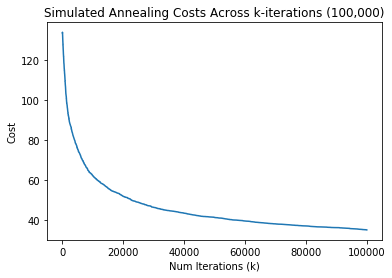

In [28]:
plt.plot(cost_list)
plt.ylabel('Cost')
plt.xlabel('Num Iterations (k)')
plt.title('Simulated Annealing Costs Across k-iterations (100,000)')
plt.show()

## Greedy Algorithms
First, we will examine various greedy algorithms and their effectiveness on the data. 

### Nearest Neighbor

The nearest neighbor algorithm is very simple and simply starts at a random node (or station in our example) and continues to visit unvisited nodes that are as close to the last visited node as possible .

**Psuedocode:** \
These are the steps of the algorithm:

    Initialize all vertices as unvisited.
    Select an arbitrary vertex, set it as the current vertex u. Mark u as visited.
    Find out the shortest edge connecting the current vertex u and an unvisited vertex v.
    Set v as the current vertex u. Mark v as visited.
    If all the vertices in the domain are visited, then terminate. Else, go to step 3.

The sequence of the visited vertices is the output of the algorithm. 

**Time complexity:** Worst Case O(N^2)

**Space complexity:** Worst Case O(N)

[Source (wikipedia)](https://en.wikipedia.org/wiki/Nearest_neighbour_algorithm)

In [45]:
# Nearest Neighbor
def nearest_neighbor(stations, start_ind = -1):
    cost = 0
    uniques = stations.copy()
    if start_ind < 0:
        start = uniques[np.random.randint(len(uniques))]
    else:
        start = uniques[start_ind]
    unvisited = set(uniques)
    path = [start]
    unvisited.remove(start)
    for _ in tqdm(range(len(unvisited))):
        last = path[-1]
        idx1 = station_to_idx[last]
        min_cost = np.Inf
        for station in unvisited:
            idx2 = station_to_idx[station]
            dist = get_edge_cost(last, station)
            if dist < min_cost:
                min_cost = dist
                min_station = station
        unvisited.remove(min_station)
        path.append(min_station)
        cost += min_cost
            
    return path, cost

In [46]:
nn_path, nn_cost = nearest_neighbor(stations, 0)
nn_path.append(stations[0])
print('cost: ',calPathDist(nn_path))

100%|██████████| 1487/1487 [00:00<00:00, 2133.13it/s]

cost:  5.169357498714313


### Farthest-First Traversal (Farthest Insertion)

**PseudoCode:**\
The farthest-first traversal of a finite point set may be computed by a greedy algorithm that maintains the distance of each point from the previously selected points, performing the following steps:[3]

    Initialize the sequence of selected points to the empty sequence, and the distances of each point to the selected points to infinity.
    While not all points have been selected, repeat the following steps:
        Scan the list of not-yet-selected points to find a point p that has maximum distance from the selected points.
        Remove p from the not-yet-selected points and add it to the end of the sequence of selected points.
        For each remaining not-yet-selected point q, replace the distance stored for q by the minimum of its old value and the distance from p to q.

**Time complexity:** Worst Case O(N^2)

**Space complexity:** Worst Case O(N)

[Source (wikipedia)](https://en.wikipedia.org/wiki/Farthest-first_traversal)


#### Farthest Insertion 
**PseudoCode:**
 1. Start with a sub-graph consisting of node i only.
 2. Find node r such that cir is maximal and form sub-tour i-r-i.
 3. (Selection step) Given a sub-tour, find node r not in the sub-tour farthest from any node in the sub-tour; i.e. with maximal crj
 4. (Insertion step) Find the arc (i, j) in the sub-tour which minimizes cir + crj - cij . Insert r between i and j.
 5. If all the nodes are added to the tour, stop. Else go to step 3

https://www2.isye.gatech.edu/~mgoetsch/cali/VEHICLE/TSP/TSP015__.HTM


In [32]:
np.NINF

-inf

In [33]:
np.PINF

inf

In [39]:
# Farthest-First Traversal
def farthest_first(stations, start_ind=-1):
    cost = 0
    uniques = stations.copy()
    if start_ind < 0:
        start = uniques[np.random.randint(len(uniques))]
    else:
        start = uniques[start_ind]
    unvisited = set(uniques)
    path = [start]
    unvisited.remove(start)
    for _ in tqdm(range(len(unvisited))):
        last = path[-1]
        idx1 = station_to_idx[last]
        max_cost = np.NINF
        # Selection Step
        for station in unvisited:
            idx2 = station_to_idx[station]
            dist = get_edge_cost(last, station)
            if dist > max_cost:
                max_cost = dist
                max_station = station
        unvisited.remove(max_station)
        # Insertion Step
        cost_change = np.PINF
        idx_to_insert = 0
        for idx, station in enumerate(path):
            if idx + 1 < len(path):
                cij = get_edge_cost(station, path[idx + 1])
                cir = get_edge_cost(station, max_station)
                crj = get_edge_cost(max_station, path[idx + 1])
                if (cir + crj - cij) < cost_change:
                    cost_change = cir + crj - cij
                    idx_to_insert = idx + 1
        path.insert(idx_to_insert, max_station)
        cost += max_cost
        
    return path, calPathDist(path)

In [43]:
ff_path, ff_cost = farthest_first(stations, 0)
ff_path.append(stations[0])
calPathDist(ff_path)

100%|██████████| 1487/1487 [00:02<00:00, 520.99it/s]


5.155468040509746

In [42]:
ff_path.append(stations[0])

In [ ]:
np.unique(path).shape

In [ ]:
cost

### K-opt Agorithms

#### 2-opt Algorithm

The 2-opt algorithm works as follows: take 2 arcs from the route, reconnect these arcs with each other and calculate new travel distance. If this modification has led to a shorter total travel distance the current route is updated. The algorithm continues to build on the improved route and repeats the steps.

```
procedure 2optSwap(route, i, k) {
    1. take route[0] to route[i-1] and add them in order to new_route
    2. take route[i] to route[k] and add them in reverse order to new_route
    3. take route[k+1] to end and add them in order to new_route
    return new_route;
}
```

In [ ]:
def two_opt(route):
    # 2-opt implementation here
    return

finished in 100 iterations


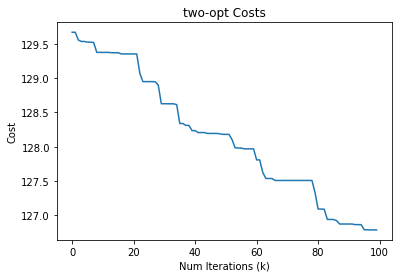

In [87]:
import matplotlib.pyplot as plt

MAXCOUNT = 100

def calPathDist(path):
    sum = 0.0
    for i in range(1, len(path)):
        sum += get_edge_cost(path[i], path[i - 1])
    return sum    

def pathCompare(path1, path2):
    if calPathDist(path1) <= calPathDist(path2):
        return True
    return False
    
def generateRandomPath(path):
    a = np.random.randint(len(path))
    while True:
        b = np.random.randint(len(path))
        if np.abs(a - b) > 1:
            break
    if a > b:
        return b, a, path[b:a+1]
    else:
        return a, b, path[a:b+1]
    
def reversePath(path):
    rePath = path.copy()
    rePath[1:-1] = rePath[-2:0:-1]
    return rePath
    
def updateBestPath(bestPath, lim):
    count = 0
    itr = 0
    costs = []
    while count < MAXCOUNT and itr < lim:
        itr += 1
#         print("updated path costs to", calPathDist(bestPath))
#         print(bestPath.tolist())
        costs.append(calPathDist(bestPath))
        start, end, path = generateRandomPath(bestPath)
        rePath = reversePath(path)
        if pathCompare(path, rePath):
            count += 1
            continue
        else:
            count = 0
            bestPath[start:end+1] = rePath
#     plot_costs(costs, "2-opt")
    print("finished in", itr, "iterations")
    return bestPath, costs
    
def two_opt(stations, shuffle=True, lim=np.PINF):
    bestPath = stations.copy()
    if shuffle:
        np.random.shuffle(bestPath)
    bestPath = np.append(bestPath, bestPath[0])
    bestPath, cost_list = updateBestPath(bestPath, lim)
    return calPathDist(bestPath), bestPath, cost_list

def plot_costs(cost_list, alg_name="Algorithm"):
    plt.plot(cost_list)
    plt.ylabel('Cost')
    plt.xlabel('Num Iterations (k)')
    plt.title(alg_name + ' Costs')
    plt.show()
    
two_opt_cost, two_opt_path, cost_list = two_opt(stations, lim=100)

plot_costs(cost_list, "two-opt")


 33%|███▎      | 3/9 [00:00<00:00, 16.03it/s]

finished in 100 iterations
current route cost is 0.26124128985583206
finished in 187 iterations
current route cost is 0.4056224957349204
current route cost is 0.3182808303821715
current route cost is 0.2836024572210354
current route cost is 0.27486969857442123
current route cost is 0.2697149623240053
finished in 423 iterations
current route cost is 0.7368162521651558
current route cost is 0.5448953694033118
current route cost is 0.4685908975622697
current route cost is 0.4295482976163709
current route cost is 0.39482888851732223
current route cost is 0.38886758969437063
finished in 448 iterations
current route cost is 0.8922588771215123
current route cost is 0.6607617196228774
current route cost is 0.5750212245806762
current route cost is 0.5148623221680079
current route cost is 0.4732938737423032
current route cost is 0.44207113349772514


 44%|████▍     | 4/9 [00:01<00:01,  3.48it/s]

current route cost is 0.41256374161790327
current route cost is 0.40123611456351693
current route cost is 0.3958861879411339
current route cost is 0.3958861879411338
finished in 769 iterations
current route cost is 1.2164531222562922
current route cost is 0.9849559647576576
current route cost is 0.8009638127728392
current route cost is 0.7069002845135406
current route cost is 0.6155499590322466
current route cost is 0.578638923267884
current route cost is 0.549131531388062
current route cost is 0.5243506014751569
current route cost is 0.5221034597758727
current route cost is 0.5213351345471794
current route cost is 0.5111248445685195
current route cost is 0.5042862795216585
current route cost is 0.4840780768424127


 56%|█████▌    | 5/9 [00:04<00:05,  1.29s/it]

current route cost is 0.48407807684241266
finished in 636 iterations
current route cost is 1.6466248520661524
current route cost is 1.379571923431222
current route cost is 1.1480518554723171
current route cost is 0.9460635168875323
current route cost is 0.8119682242627307
current route cost is 0.7433817495225072
current route cost is 0.6898151571482546
current route cost is 0.6526586790196588
current route cost is 0.6096303256607215
current route cost is 0.5959633660592645
current route cost is 0.5849471042111822
current route cost is 0.5763026980558706
current route cost is 0.5634507181333424
current route cost is 0.5482813284966241
current route cost is 0.5441810704946388


 67%|██████▋   | 6/9 [00:13<00:10,  3.50s/it]

current route cost is 0.5440156571220437
current route cost is 0.5413067989845269
finished in 678 iterations
current route cost is 2.254234246913127
current route cost is 1.951402349961687
current route cost is 1.687837038149111
current route cost is 1.4461524408931519
current route cost is 1.219271034066113
current route cost is 1.0571649846549136
current route cost is 0.9286870305736032
current route cost is 0.840211042386896
current route cost is 0.7769318255315034
current route cost is 0.7358140763776138
current route cost is 0.7096738883703942
current route cost is 0.6876489782623226
current route cost is 0.6739820186608657
current route cost is 0.665337612505554


 78%|███████▊  | 7/9 [00:28<00:13,  6.95s/it]

current route cost is 0.6524856325830257
current route cost is 0.6373162429463075
finished in 784 iterations
current route cost is 2.811202942369715
current route cost is 2.4880314324872823
current route cost is 2.1933677867582637
current route cost is 1.9107483606030635
current route cost is 1.6467440635661734
current route cost is 1.428611859179345
current route cost is 1.2309783343649252
current route cost is 1.1002024081926098
current route cost is 1.0252895183416781
current route cost is 0.9518178557151562
current route cost is 0.8981564646169593
current route cost is 0.8563433084983063
current route cost is 0.8269253240584469
current route cost is 0.8008084161675896
current route cost is 0.7748308388809142
current route cost is 0.7595224204339815
current route cost is

 89%|████████▉ | 8/9 [00:59<00:14, 14.11s/it]

 0.7494737454073523
current route cost is 0.7468370405186511
current route cost is 0.7369037277026951
finished in 766 iterations
current route cost is 3.030788144267855
current route cost is 2.7077939898468917
current route cost is 2.4168901158932776
current route cost is 2.1452757112746776
current route cost is 1.8992316281608097
current route cost is 1.6765262886705932
current route cost is 1.4891404024445494
current route cost is 1.317498836676019
current route cost is 1.1849299726391012
current route cost is 1.1053308484524649
current route cost is 1.0274975448980448
current route cost is 0.9560690040603721
current route cost is 0.9208457202211666
current route cost is 0.8876148053715127
current route cost is 0.8563040183892243
current route cost is 0.8382260712380801
current route cost is 0.8226092178772887
current route cost is 0.8111590406046962
current route cost is 0.800991482557655
current route cost is 0.794152917510794
current route cost is 0.783081483584315
current route c

100%|██████████| 9/9 [02:03<00:00, 13.69s/it]

 0.7698346114530423


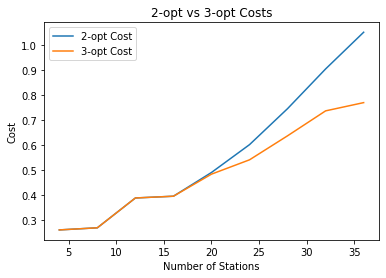

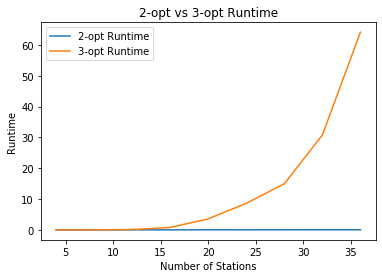

In [103]:
# def test_k_opt():
two_costs = []
two_runtime = []
three_costs = []
three_runtime = []
for i in tqdm(range(4, 40, 4)):
    start = time.time()
    cost, _, _ = two_opt(stations[:i], shuffle=False)
    end = time.time()
    two_costs.append(cost)
    two_runtime.append(end - start)

    start = time.time()
    cost, _= three_opt(stations[:i], shuffle=False)
    end = time.time()
    three_costs.append(cost)
    three_runtime.append(end - start)
plt.plot(range(4, 40, 4), two_costs, label="2-opt Cost")
plt.plot(range(4, 40, 4), three_costs, label="3-opt Cost")
plt.ylabel('Cost')
plt.xlabel('Number of Stations')
plt.legend()
plt.title('2-opt vs 3-opt Costs')
plt.show()

plt.plot(range(4, 40, 4), two_runtime, label="2-opt Runtime")
plt.plot(range(4, 40, 4), three_runtime, label="3-opt Runtime")
plt.ylabel('Runtime')
plt.xlabel('Number of Stations')
plt.legend()
plt.title('2-opt vs 3-opt Runtime')
plt.show()

In [101]:
two_costs

[]

#### 3-opt Algorithm
3-opt analysis involves deleting 3 connections (or edges) in a network (or tour), to create 3 sub-tours. Then the 7 different ways of reconnecting the network are analysed to find the optimum one. This process is then repeated for a different set of 3 connections, until all possible combinations have been tried in a network. A single execution of 3-opt has a time complexity of $O(n^{3})$.


In [28]:
import random
import numpy as np
import matplotlib.pyplot as plt
# import TWOPT
from itertools import combinations, permutations



def exchange(path, mode, a, c, e):
    """
    path: sequence of station_id with i th being starting and i + 1 th being ending staions
    mode: mode of exchanging
    a, c, e: index of stations
    """
    b, d, f = a + 1, c + 1, e + 1
    
    
    
    if mode == 0:
        # remain unchanged
        return path, 0
    elif mode == 1:
        # 2-opt (a, e)[d, c](b, f)
        sol = np.concatenate((path[: a + 1], path[e: d - 1: -1], path[c: b - 1: -1], path[f:]))
    elif mode == 2:
        # 2-opt [a, c](b, d)[e, f]
        sol = np.concatenate((path[: a + 1], path[b: c + 1], path[e:d - 1: -1], path[f:]))
    elif mode == 3:
        # 2-opt (a, c)(b, d)[e, f]
        sol = np.concatenate((path[: a + 1], path[c: b - 1: -1], path[d: e + 1], path[f:]))
    elif mode == 4:
        # 3-opt (a, c)(b, e)(d, f)
        sol = np.concatenate((path[: a + 1], path[c: b - 1: -1], path[e: d - 1: -1], path[f:]))
    elif mode == 5:
        # 3-opt (a, e)(d, b)(c, f)
        sol = np.concatenate((path[: a + 1], path[e: d - 1: -1], path[b: c + 1], path[f:]))
    elif mode == 6:
        # 3-opt (a, d)(e, c)(b, f)
        sol = np.concatenate((path[: a + 1], path[d: e + 1], path[c: b - 1: -1], path[f:]))
    elif mode == 7:
        # 3-opt (a, d)(e, b)(c, f)
        sol = np.concatenate((path[: a + 1], path[d: e + 1], path[b: c + 1], path[f:]))
    
    base = calPathDist(path)
    newCost = calPathDist(sol)
    return sol, base - newCost

def three_opt_search(bestPath, lim):
    size = len(bestPath)
    bestCost = calPathDist(bestPath)
    bestChange = 1
    costs = []
    itr = 0
    while bestChange > 0 and itr < lim:
        itr += 1
        saved, bestChange = three_opt_update(bestPath, size)
        print("current route cost is", bestCost)
        costs.append(bestCost)
        if bestChange > 0 or itr == lim:
            a, c, e, mode = saved
            bestPath, change = exchange(bestPath, mode, a, c, e)
            bestCost -= change
    return bestPath, bestCost
#     plot_costs(costs, "3-opt")

def three_opt_update(bestPath, size):
    bestChange = 0
    saved = None
    for a in range(size - 5):
        for c in range(a + 2, size - 3):
            for e in range(c + 2, size - 1):
                change = 0
#                 print(a, c, e, change, bestChange)
                for i in range(8):
                    path, change = exchange(bestPath, i, a, c, e)
                    
                    if change > bestChange:
                        saved = a, c, e, i
                        bestChange = change
                    
    return saved, bestChange
        
def three_opt(stations, shuffle=True, lim=np.PINF):
    bestPath = stations.copy()
    if shuffle:
        np.random.shuffle(bestPath)
    bestPath = np.append(bestPath, stations[0])
    bestPath, bestCost = three_opt_search(bestPath, lim)
    return bestCost, bestPath

0 2 4 0 0
0 2 5 0 0.06880571374022093
0 2 6 0 0.06880571374022093
0 2 7 0 0.07507612940369635
0 2 8 0 0.07507612940369635
0 2 9 0 0.07507612940369635
0 2 10 0 0.07507612940369635
0 2 11 0 0.07507612940369635
0 2 12 0 0.07507612940369635
0 2 13 0 0.07507612940369635
0 2 14 0 0.07507612940369635
0 2 15 0 0.07507612940369635
0 2 16 0 0.07507612940369635
0 2 17 0 0.07507612940369635
0 2 18 0 0.07507612940369635
0 2 19 0 0.07507612940369635
0 3 5 0 0.07507612940369635
0 3 6 0 0.14663688322618995
0 3 7 0 0.14663688322618995
0 3 8 0 0.14663688322618995
0 3 9 0 0.14663688322618995
0 3 10 0 0.1560451595696979
0 3 11 0 0.1560451595696979
0 3 12 0 0.1560451595696979
0 3 13 0 0.1560451595696979
0 3 14 0 0.1560451595696979
0 3 15 0 0.1560451595696979
0 3 16 0 0.1560451595696979
0 3 17 0 0.1560451595696979
0 3 18 0 0.1560451595696979
0 3 19 0 0.1560451595696979
0 4 6 0 0.1560451595696979
0 4 7 0 0.1560451595696979
0 4 8 0 0.1560451595696979
0 4 9 0 0.1560451595696979
0 4 10 0 0.18292328945644254
0 4

2 9 11 0 0.21889938568117007
2 9 12 0 0.21889938568117007
2 9 13 0 0.21889938568117007
2 9 14 0 0.21889938568117007
2 9 15 0 0.21889938568117007
2 9 16 0 0.21889938568117007
2 9 17 0 0.21889938568117007
2 9 18 0 0.21889938568117007
2 9 19 0 0.21889938568117007
2 10 12 0 0.21889938568117007
2 10 13 0 0.21889938568117007
2 10 14 0 0.21889938568117007
2 10 15 0 0.21889938568117007
2 10 16 0 0.21889938568117007
2 10 17 0 0.21889938568117007
2 10 18 0 0.21889938568117007
2 10 19 0 0.21889938568117007
2 11 13 0 0.21889938568117007
2 11 14 0 0.21889938568117007
2 11 15 0 0.21889938568117007
2 11 16 0 0.21889938568117007
2 11 17 0 0.21889938568117007
2 11 18 0 0.21889938568117007
2 11 19 0 0.21889938568117007
2 12 14 0 0.21889938568117007
2 12 15 0 0.21889938568117007
2 12 16 0 0.21889938568117007
2 12 17 0 0.21889938568117007
2 12 18 0 0.21889938568117007
2 12 19 0 0.21889938568117007
2 13 15 0 0.21889938568117007
2 13 16 0 0.21889938568117007
2 13 17 0 0.21889938568117007
2 13 18 0 0.2188993

6 10 13 0 0.22912279754539333
6 10 14 0 0.22912279754539333
6 10 15 0 0.22912279754539333
6 10 16 0 0.22912279754539333
6 10 17 0 0.22912279754539333
6 10 18 0 0.22912279754539333
6 10 19 0 0.22912279754539333
6 11 13 0 0.22912279754539333
6 11 14 0 0.22912279754539333
6 11 15 0 0.22912279754539333
6 11 16 0 0.22912279754539333
6 11 17 0 0.22912279754539333
6 11 18 0 0.22912279754539333
6 11 19 0 0.22912279754539333
6 12 14 0 0.22912279754539333
6 12 15 0 0.22912279754539333
6 12 16 0 0.22912279754539333
6 12 17 0 0.22912279754539333
6 12 18 0 0.22912279754539333
6 12 19 0 0.22912279754539333
6 13 15 0 0.22912279754539333
6 13 16 0 0.22912279754539333
6 13 17 0 0.22912279754539333
6 13 18 0 0.22912279754539333
6 13 19 0 0.22912279754539333
6 14 16 0 0.22912279754539333
6 14 17 0 0.22912279754539333
6 14 18 0 0.22912279754539333
6 14 19 0 0.22912279754539333
6 15 17 0 0.22912279754539333
6 15 18 0 0.22912279754539333
6 15 19 0 0.22912279754539333
6 16 18 0 0.22912279754539333
6 16 19 0 

0 9 19 0 0.18276055810307512
0 10 12 0 0.18276055810307512
0 10 13 0 0.18276055810307512
0 10 14 0 0.18276055810307512
0 10 15 0 0.18276055810307512
0 10 16 0 0.18276055810307512
0 10 17 0 0.18276055810307512
0 10 18 0 0.18276055810307512
0 10 19 0 0.18276055810307512
0 11 13 0 0.18276055810307512
0 11 14 0 0.18276055810307512
0 11 15 0 0.18276055810307512
0 11 16 0 0.18276055810307512
0 11 17 0 0.18276055810307512
0 11 18 0 0.18276055810307512
0 11 19 0 0.18276055810307512
0 12 14 0 0.18276055810307512
0 12 15 0 0.18276055810307512
0 12 16 0 0.18276055810307512
0 12 17 0 0.18276055810307512
0 12 18 0 0.18276055810307512
0 12 19 0 0.18276055810307512
0 13 15 0 0.18276055810307512
0 13 16 0 0.18276055810307512
0 13 17 0 0.18276055810307512
0 13 18 0 0.18276055810307512
0 13 19 0 0.18276055810307512
0 14 16 0 0.18276055810307512
0 14 17 0 0.18276055810307512
0 14 18 0 0.18276055810307512
0 14 19 0 0.18276055810307512
0 15 17 0 0.18276055810307512
0 15 18 0 0.18276055810307512
0 15 19 0 0

3 8 12 0 0.18658311264943261
3 8 13 0 0.18658311264943261
3 8 14 0 0.18658311264943261
3 8 15 0 0.18658311264943261
3 8 16 0 0.18658311264943261
3 8 17 0 0.18658311264943261
3 8 18 0 0.18658311264943261
3 8 19 0 0.18658311264943261
3 9 11 0 0.18658311264943261
3 9 12 0 0.18658311264943261
3 9 13 0 0.18658311264943261
3 9 14 0 0.18658311264943261
3 9 15 0 0.18658311264943261
3 9 16 0 0.18658311264943261
3 9 17 0 0.18658311264943261
3 9 18 0 0.18658311264943261
3 9 19 0 0.18658311264943261
3 10 12 0 0.18658311264943261
3 10 13 0 0.18658311264943261
3 10 14 0 0.18658311264943261
3 10 15 0 0.18658311264943261
3 10 16 0 0.18658311264943261
3 10 17 0 0.18658311264943261
3 10 18 0 0.18658311264943261
3 10 19 0 0.18658311264943261
3 11 13 0 0.18658311264943261
3 11 14 0 0.18658311264943261
3 11 15 0 0.18658311264943261
3 11 16 0 0.18658311264943261
3 11 17 0 0.18658311264943261
3 11 18 0 0.18658311264943261
3 11 19 0 0.18658311264943261
3 12 14 0 0.18658311264943261
3 12 15 0 0.186583112649432

8 10 15 0 0.20635458476816448
8 10 16 0 0.20635458476816448
8 10 17 0 0.20635458476816448
8 10 18 0 0.20635458476816448
8 10 19 0 0.20635458476816448
8 11 13 0 0.20635458476816448
8 11 14 0 0.20635458476816448
8 11 15 0 0.20635458476816448
8 11 16 0 0.20635458476816448
8 11 17 0 0.20635458476816448
8 11 18 0 0.20635458476816448
8 11 19 0 0.20635458476816448
8 12 14 0 0.20635458476816448
8 12 15 0 0.20635458476816448
8 12 16 0 0.20635458476816448
8 12 17 0 0.20635458476816448
8 12 18 0 0.20635458476816448
8 12 19 0 0.20635458476816448
8 13 15 0 0.20635458476816448
8 13 16 0 0.20635458476816448
8 13 17 0 0.20635458476816448
8 13 18 0 0.20635458476816448
8 13 19 0 0.20635458476816448
8 14 16 0 0.20635458476816448
8 14 17 0 0.20635458476816448
8 14 18 0 0.20635458476816448
8 14 19 0 0.20635458476816448
8 15 17 0 0.20635458476816448
8 15 18 0 0.20635458476816448
8 15 19 0 0.20635458476816448
8 16 18 0 0.20635458476816448
8 16 19 0 0.20635458476816448
8 17 19 0 0.20635458476816448
9 11 13 0 

1 6 12 0 0.16475026598465092
1 6 13 0 0.16475026598465092
1 6 14 0 0.16475026598465092
1 6 15 0 0.16475026598465092
1 6 16 0 0.16475026598465092
1 6 17 0 0.16475026598465092
1 6 18 0 0.16475026598465092
1 6 19 0 0.16475026598465092
1 7 9 0 0.16475026598465092
1 7 10 0 0.16475026598465092
1 7 11 0 0.16475026598465092
1 7 12 0 0.16475026598465092
1 7 13 0 0.16475026598465092
1 7 14 0 0.16475026598465092
1 7 15 0 0.16475026598465092
1 7 16 0 0.16475026598465092
1 7 17 0 0.16475026598465092
1 7 18 0 0.16475026598465092
1 7 19 0 0.16475026598465092
1 8 10 0 0.16475026598465092
1 8 11 0 0.16475026598465092
1 8 12 0 0.16475026598465092
1 8 13 0 0.16475026598465092
1 8 14 0 0.16475026598465092
1 8 15 0 0.16475026598465092
1 8 16 0 0.16475026598465092
1 8 17 0 0.16475026598465092
1 8 18 0 0.16475026598465092
1 8 19 0 0.16475026598465092
1 9 11 0 0.16475026598465092
1 9 12 0 0.16475026598465092
1 9 13 0 0.16475026598465092
1 9 14 0 0.16475026598465092
1 9 15 0 0.16475026598465092
1 9 16 0 0.1647

4 8 17 0 0.16475026598465092
4 8 18 0 0.16475026598465092
4 8 19 0 0.16475026598465092
4 9 11 0 0.16475026598465092
4 9 12 0 0.16475026598465092
4 9 13 0 0.16475026598465092
4 9 14 0 0.16475026598465092
4 9 15 0 0.16475026598465092
4 9 16 0 0.16475026598465092
4 9 17 0 0.16475026598465092
4 9 18 0 0.16475026598465092
4 9 19 0 0.16475026598465092
4 10 12 0 0.16475026598465092
4 10 13 0 0.16475026598465092
4 10 14 0 0.16475026598465092
4 10 15 0 0.16475026598465092
4 10 16 0 0.16475026598465092
4 10 17 0 0.16475026598465092
4 10 18 0 0.16475026598465092
4 10 19 0 0.16475026598465092
4 11 13 0 0.16475026598465092
4 11 14 0 0.16475026598465092
4 11 15 0 0.16475026598465092
4 11 16 0 0.16475026598465092
4 11 17 0 0.16475026598465092
4 11 18 0 0.16475026598465092
4 11 19 0 0.16475026598465092
4 12 14 0 0.16475026598465092
4 12 15 0 0.16475026598465092
4 12 16 0 0.16475026598465092
4 12 17 0 0.16475026598465092
4 12 18 0 0.16475026598465092
4 12 19 0 0.16475026598465092
4 13 15 0 0.1647502659

11 13 16 0 0.16475026598465092
11 13 17 0 0.16475026598465092
11 13 18 0 0.16475026598465092
11 13 19 0 0.16475026598465092
11 14 16 0 0.16475026598465092
11 14 17 0 0.16475026598465092
11 14 18 0 0.16475026598465092
11 14 19 0 0.16475026598465092
11 15 17 0 0.16475026598465092
11 15 18 0 0.16475026598465092
11 15 19 0 0.16475026598465092
11 16 18 0 0.16475026598465092
11 16 19 0 0.16475026598465092
11 17 19 0 0.16475026598465092
12 14 16 0 0.16475026598465092
12 14 17 0 0.16475026598465092
12 14 18 0 0.16475026598465092
12 14 19 0 0.16475026598465092
12 15 17 0 0.16475026598465092
12 15 18 0 0.16475026598465092
12 15 19 0 0.16475026598465092
12 16 18 0 0.16475026598465092
12 16 19 0 0.16475026598465092
12 17 19 0 0.16475026598465092
13 15 17 0 0.16475026598465092
13 15 18 0 0.16475026598465092
13 15 19 0 0.16475026598465092
13 16 18 0 0.16475026598465092
13 16 19 0 0.16475026598465092
13 17 19 0 0.16475026598465092
14 16 18 0 0.16475026598465092
14 16 19 0 0.16475026598465092
14 17 19

2 4 16 0 0.10781506889894144
2 4 17 0 0.10781506889894144
2 4 18 0 0.10781506889894144
2 4 19 0 0.10781506889894144
2 5 7 0 0.10781506889894144
2 5 8 0 0.10781506889894144
2 5 9 0 0.10781506889894144
2 5 10 0 0.10781506889894144
2 5 11 0 0.10781506889894144
2 5 12 0 0.10781506889894144
2 5 13 0 0.10781506889894144
2 5 14 0 0.10781506889894144
2 5 15 0 0.10781506889894144
2 5 16 0 0.10781506889894144
2 5 17 0 0.10781506889894144
2 5 18 0 0.10781506889894144
2 5 19 0 0.10781506889894144
2 6 8 0 0.11810969431454266
2 6 9 0 0.11810969431454266
2 6 10 0 0.11810969431454266
2 6 11 0 0.11810969431454266
2 6 12 0 0.11810969431454266
2 6 13 0 0.11810969431454266
2 6 14 0 0.11810969431454266
2 6 15 0 0.11810969431454266
2 6 16 0 0.11810969431454266
2 6 17 0 0.11810969431454266
2 6 18 0 0.11810969431454266
2 6 19 0 0.11810969431454266
2 7 9 0 0.11810969431454266
2 7 10 0 0.11810969431454266
2 7 11 0 0.11810969431454266
2 7 12 0 0.11810969431454266
2 7 13 0 0.11810969431454266
2 7 14 0 0.118109694

5 10 18 0 0.12394099218994648
5 10 19 0 0.12394099218994648
5 11 13 0 0.12394099218994648
5 11 14 0 0.12394099218994648
5 11 15 0 0.12394099218994648
5 11 16 0 0.12394099218994648
5 11 17 0 0.12394099218994648
5 11 18 0 0.12394099218994648
5 11 19 0 0.12394099218994648
5 12 14 0 0.12394099218994648
5 12 15 0 0.12394099218994648
5 12 16 0 0.12394099218994648
5 12 17 0 0.12394099218994648
5 12 18 0 0.12394099218994648
5 12 19 0 0.12394099218994648
5 13 15 0 0.12394099218994648
5 13 16 0 0.12394099218994648
5 13 17 0 0.12394099218994648
5 13 18 0 0.12394099218994648
5 13 19 0 0.12394099218994648
5 14 16 0 0.12394099218994648
5 14 17 0 0.12394099218994648
5 14 18 0 0.12394099218994648
5 14 19 0 0.12394099218994648
5 15 17 0 0.12394099218994648
5 15 18 0 0.12394099218994648
5 15 19 0 0.12394099218994648
5 16 18 0 0.12394099218994648
5 16 19 0 0.12394099218994648
5 17 19 0 0.12394099218994648
6 8 10 0 0.12394099218994648
6 8 11 0 0.12394099218994648
6 8 12 0 0.12394099218994648
6 8 13 0 0.12

0 6 9 0 0.04796229299833421
0 6 10 0 0.04796229299833421
0 6 11 0 0.04796229299833421
0 6 12 0 0.04796229299833421
0 6 13 0 0.04796229299833421
0 6 14 0 0.04796229299833421
0 6 15 0 0.04796229299833421
0 6 16 0 0.04796229299833421
0 6 17 0 0.04796229299833421
0 6 18 0 0.04796229299833421
0 6 19 0 0.04796229299833421
0 7 9 0 0.04796229299833421
0 7 10 0 0.04796229299833421
0 7 11 0 0.04796229299833421
0 7 12 0 0.04796229299833421
0 7 13 0 0.04796229299833421
0 7 14 0 0.04796229299833421
0 7 15 0 0.04796229299833421
0 7 16 0 0.04796229299833421
0 7 17 0 0.04796229299833421
0 7 18 0 0.04796229299833421
0 7 19 0 0.04796229299833421
0 8 10 0 0.04796229299833421
0 8 11 0 0.04796229299833421
0 8 12 0 0.04796229299833421
0 8 13 0 0.04796229299833421
0 8 14 0 0.04796229299833421
0 8 15 0 0.04796229299833421
0 8 16 0 0.04796229299833421
0 8 17 0 0.04796229299833421
0 8 18 0 0.04796229299833421
0 8 19 0 0.04796229299833421
0 9 11 0 0.04796229299833421
0 9 12 0 0.04796229299833421
0 9 13 0 0.04796

3 7 10 0 0.06891936354724015
3 7 11 0 0.06891936354724015
3 7 12 0 0.06891936354724015
3 7 13 0 0.06891936354724015
3 7 14 0 0.06891936354724015
3 7 15 0 0.06891936354724015
3 7 16 0 0.06891936354724015
3 7 17 0 0.06891936354724015
3 7 18 0 0.06891936354724015
3 7 19 0 0.06891936354724015
3 8 10 0 0.06891936354724015
3 8 11 0 0.06891936354724015
3 8 12 0 0.06891936354724015
3 8 13 0 0.06891936354724015
3 8 14 0 0.06891936354724015
3 8 15 0 0.06891936354724015
3 8 16 0 0.06891936354724015
3 8 17 0 0.06891936354724015
3 8 18 0 0.06891936354724015
3 8 19 0 0.06891936354724015
3 9 11 0 0.06891936354724015
3 9 12 0 0.06891936354724015
3 9 13 0 0.06891936354724015
3 9 14 0 0.06891936354724015
3 9 15 0 0.06891936354724015
3 9 16 0 0.06891936354724015
3 9 17 0 0.06891936354724015
3 9 18 0 0.06891936354724015
3 9 19 0 0.06891936354724015
3 10 12 0 0.06891936354724015
3 10 13 0 0.06891936354724015
3 10 14 0 0.06891936354724015
3 10 15 0 0.06891936354724015
3 10 16 0 0.06891936354724015
3 10 17 0

8 10 18 0 0.07484769656511048
8 10 19 0 0.07484769656511048
8 11 13 0 0.07484769656511048
8 11 14 0 0.07484769656511048
8 11 15 0 0.07484769656511048
8 11 16 0 0.07484769656511048
8 11 17 0 0.07484769656511048
8 11 18 0 0.07484769656511048
8 11 19 0 0.07484769656511048
8 12 14 0 0.07484769656511048
8 12 15 0 0.07484769656511048
8 12 16 0 0.07484769656511048
8 12 17 0 0.07484769656511048
8 12 18 0 0.07484769656511048
8 12 19 0 0.07484769656511048
8 13 15 0 0.07484769656511048
8 13 16 0 0.07484769656511048
8 13 17 0 0.07484769656511048
8 13 18 0 0.07484769656511048
8 13 19 0 0.07484769656511048
8 14 16 0 0.07484769656511048
8 14 17 0 0.07484769656511048
8 14 18 0 0.07484769656511048
8 14 19 0 0.07484769656511048
8 15 17 0 0.07484769656511048
8 15 18 0 0.07484769656511048
8 15 19 0 0.07484769656511048
8 16 18 0 0.07484769656511048
8 16 19 0 0.07484769656511048
8 17 19 0 0.07484769656511048
9 11 13 0 0.07484769656511048
9 11 14 0 0.07484769656511048
9 11 15 0 0.07484769656511048
9 11 16 0 

1 9 17 0 0.0450243957147789
1 9 18 0 0.0450243957147789
1 9 19 0 0.0450243957147789
1 10 12 0 0.0450243957147789
1 10 13 0 0.0450243957147789
1 10 14 0 0.0450243957147789
1 10 15 0 0.0450243957147789
1 10 16 0 0.0450243957147789
1 10 17 0 0.0450243957147789
1 10 18 0 0.0450243957147789
1 10 19 0 0.0450243957147789
1 11 13 0 0.0450243957147789
1 11 14 0 0.0450243957147789
1 11 15 0 0.0450243957147789
1 11 16 0 0.0450243957147789
1 11 17 0 0.0450243957147789
1 11 18 0 0.0450243957147789
1 11 19 0 0.0450243957147789
1 12 14 0 0.0450243957147789
1 12 15 0 0.0450243957147789
1 12 16 0 0.0450243957147789
1 12 17 0 0.0450243957147789
1 12 18 0 0.0450243957147789
1 12 19 0 0.0450243957147789
1 13 15 0 0.0450243957147789
1 13 16 0 0.0450243957147789
1 13 17 0 0.0450243957147789
1 13 18 0 0.0450243957147789
1 13 19 0 0.0450243957147789
1 14 16 0 0.0450243957147789
1 14 17 0 0.0450243957147789
1 14 18 0 0.0450243957147789
1 14 19 0 0.0450243957147789
1 15 17 0 0.0450243957147789
1 15 18 0 0.04502

5 7 11 0 0.0450243957147789
5 7 12 0 0.0450243957147789
5 7 13 0 0.0450243957147789
5 7 14 0 0.0450243957147789
5 7 15 0 0.0450243957147789
5 7 16 0 0.0450243957147789
5 7 17 0 0.0450243957147789
5 7 18 0 0.0450243957147789
5 7 19 0 0.0450243957147789
5 8 10 0 0.0450243957147789
5 8 11 0 0.0450243957147789
5 8 12 0 0.0450243957147789
5 8 13 0 0.0450243957147789
5 8 14 0 0.0450243957147789
5 8 15 0 0.0450243957147789
5 8 16 0 0.0450243957147789
5 8 17 0 0.0450243957147789
5 8 18 0 0.0450243957147789
5 8 19 0 0.0450243957147789
5 9 11 0 0.0450243957147789
5 9 12 0 0.0450243957147789
5 9 13 0 0.0450243957147789
5 9 14 0 0.0450243957147789
5 9 15 0 0.0450243957147789
5 9 16 0 0.0450243957147789
5 9 17 0 0.0450243957147789
5 9 18 0 0.0450243957147789
5 9 19 0 0.0450243957147789
5 10 12 0 0.0450243957147789
5 10 13 0 0.0450243957147789
5 10 14 0 0.0450243957147789
5 10 15 0 0.0450243957147789
5 10 16 0 0.0450243957147789
5 10 17 0 0.0450243957147789
5 10 18 0 0.0450243957147789
5 10 19 0 0.0

0 4 15 0 0
0 4 16 0 0
0 4 17 0 0
0 4 18 0 0
0 4 19 0 0
0 5 7 0 0
0 5 8 0 0.017856941538179738
0 5 9 0 0.017856941538179738
0 5 10 0 0.017856941538179738
0 5 11 0 0.017856941538179738
0 5 12 0 0.017856941538179738
0 5 13 0 0.017856941538179738
0 5 14 0 0.017856941538179738
0 5 15 0 0.017856941538179738
0 5 16 0 0.017856941538179738
0 5 17 0 0.017856941538179738
0 5 18 0 0.017856941538179738
0 5 19 0 0.017856941538179738
0 6 8 0 0.019330240347029792
0 6 9 0 0.019330240347029792
0 6 10 0 0.019330240347029792
0 6 11 0 0.019330240347029792
0 6 12 0 0.019330240347029792
0 6 13 0 0.019330240347029792
0 6 14 0 0.019330240347029792
0 6 15 0 0.019330240347029792
0 6 16 0 0.019330240347029792
0 6 17 0 0.019330240347029792
0 6 18 0 0.019330240347029792
0 6 19 0 0.019330240347029792
0 7 9 0 0.019330240347029792
0 7 10 0 0.019330240347029792
0 7 11 0 0.019330240347029792
0 7 12 0 0.019330240347029792
0 7 13 0 0.019330240347029792
0 7 14 0 0.019330240347029792
0 7 15 0 0.019330240347029792
0 7 16 0 0

3 5 16 0 0.026270329061589215
3 5 17 0 0.026270329061589215
3 5 18 0 0.026270329061589215
3 5 19 0 0.026270329061589215
3 6 8 0 0.026270329061589215
3 6 9 0 0.026270329061589215
3 6 10 0 0.026270329061589215
3 6 11 0 0.026270329061589215
3 6 12 0 0.026270329061589215
3 6 13 0 0.026270329061589215
3 6 14 0 0.026270329061589215
3 6 15 0 0.026270329061589215
3 6 16 0 0.026270329061589215
3 6 17 0 0.026270329061589215
3 6 18 0 0.026270329061589215
3 6 19 0 0.026270329061589215
3 7 9 0 0.026270329061589215
3 7 10 0 0.026270329061589215
3 7 11 0 0.026270329061589215
3 7 12 0 0.026270329061589215
3 7 13 0 0.026270329061589215
3 7 14 0 0.026270329061589215
3 7 15 0 0.026270329061589215
3 7 16 0 0.026270329061589215
3 7 17 0 0.026270329061589215
3 7 18 0 0.026270329061589215
3 7 19 0 0.026270329061589215
3 8 10 0 0.026270329061589215
3 8 11 0 0.026270329061589215
3 8 12 0 0.026270329061589215
3 8 13 0 0.026270329061589215
3 8 14 0 0.026270329061589215
3 8 15 0 0.026270329061589215
3 8 16 0 0.02

7 13 16 0 0.05951114880171937
7 13 17 0 0.05951114880171937
7 13 18 0 0.05951114880171937
7 13 19 0 0.05951114880171937
7 14 16 0 0.05951114880171937
7 14 17 0 0.05951114880171937
7 14 18 0 0.05951114880171937
7 14 19 0 0.05951114880171937
7 15 17 0 0.05951114880171937
7 15 18 0 0.05951114880171937
7 15 19 0 0.05951114880171937
7 16 18 0 0.05951114880171937
7 16 19 0 0.05951114880171937
7 17 19 0 0.05951114880171937
8 10 12 0 0.05951114880171937
8 10 13 0 0.05951114880171937
8 10 14 0 0.05951114880171937
8 10 15 0 0.05951114880171937
8 10 16 0 0.05951114880171937
8 10 17 0 0.05951114880171937
8 10 18 0 0.05951114880171937
8 10 19 0 0.05951114880171937
8 11 13 0 0.05951114880171937
8 11 14 0 0.05951114880171937
8 11 15 0 0.05951114880171937
8 11 16 0 0.05951114880171937
8 11 17 0 0.05951114880171937
8 11 18 0 0.05951114880171937
8 11 19 0 0.05951114880171937
8 12 14 0 0.05951114880171937
8 12 15 0 0.05951114880171937
8 12 16 0 0.05951114880171937
8 12 17 0 0.05951114880171937
8 12 18 0 

1 7 18 0 0.026270329061589215
1 7 19 0 0.026270329061589215
1 8 10 0 0.026270329061589215
1 8 11 0 0.026270329061589215
1 8 12 0 0.026270329061589215
1 8 13 0 0.026270329061589215
1 8 14 0 0.026270329061589215
1 8 15 0 0.026270329061589215
1 8 16 0 0.026270329061589215
1 8 17 0 0.026270329061589215
1 8 18 0 0.026270329061589215
1 8 19 0 0.026270329061589215
1 9 11 0 0.026270329061589215
1 9 12 0 0.026270329061589215
1 9 13 0 0.026270329061589215
1 9 14 0 0.026270329061589215
1 9 15 0 0.026270329061589215
1 9 16 0 0.026270329061589215
1 9 17 0 0.026270329061589215
1 9 18 0 0.026270329061589215
1 9 19 0 0.026270329061589215
1 10 12 0 0.026270329061589215
1 10 13 0 0.026270329061589215
1 10 14 0 0.026270329061589215
1 10 15 0 0.026270329061589215
1 10 16 0 0.026270329061589215
1 10 17 0 0.026270329061589215
1 10 18 0 0.026270329061589215
1 10 19 0 0.026270329061589215
1 11 13 0 0.026270329061589215
1 11 14 0 0.026270329061589215
1 11 15 0 0.026270329061589215
1 11 16 0 0.02627032906158921

4 9 17 0 0.026270329061589215
4 9 18 0 0.026270329061589215
4 9 19 0 0.026270329061589215
4 10 12 0 0.026270329061589215
4 10 13 0 0.026270329061589215
4 10 14 0 0.026270329061589215
4 10 15 0 0.026270329061589215
4 10 16 0 0.026270329061589215
4 10 17 0 0.026270329061589215
4 10 18 0 0.026270329061589215
4 10 19 0 0.026270329061589215
4 11 13 0 0.026270329061589215
4 11 14 0 0.026270329061589215
4 11 15 0 0.026270329061589215
4 11 16 0 0.026270329061589215
4 11 17 0 0.026270329061589215
4 11 18 0 0.026270329061589215
4 11 19 0 0.026270329061589215
4 12 14 0 0.026270329061589215
4 12 15 0 0.026270329061589215
4 12 16 0 0.026270329061589215
4 12 17 0 0.026270329061589215
4 12 18 0 0.026270329061589215
4 12 19 0 0.026270329061589215
4 13 15 0 0.026270329061589215
4 13 16 0 0.026270329061589215
4 13 17 0 0.026270329061589215
4 13 18 0 0.026270329061589215
4 13 19 0 0.026270329061589215
4 14 16 0 0.026270329061589215
4 14 17 0 0.026270329061589215
4 14 18 0 0.026270329061589215
4 14 19 0 0

12 14 18 0 0.026270329061589215
12 14 19 0 0.026270329061589215
12 15 17 0 0.026270329061589215
12 15 18 0 0.026270329061589215
12 15 19 0 0.026270329061589215
12 16 18 0 0.026270329061589215
12 16 19 0 0.026270329061589215
12 17 19 0 0.026270329061589215
13 15 17 0 0.026270329061589215
13 15 18 0 0.026270329061589215
13 15 19 0 0.026270329061589215
13 16 18 0 0.026270329061589215
13 16 19 0 0.026270329061589215
13 17 19 0 0.026270329061589215
14 16 18 0 0.026270329061589215
14 16 19 0 0.026270329061589215
14 17 19 0 0.026270329061589215
15 17 19 0 0.026270329061589215
current route cost is 0.540845100353352
0 2 4 0 0
0 2 5 0 0
0 2 6 0 0
0 2 7 0 0
0 2 8 0 0
0 2 9 0 0
0 2 10 0 0
0 2 11 0 0
0 2 12 0 0
0 2 13 0 0
0 2 14 0 0
0 2 15 0 0
0 2 16 0 0
0 2 17 0 0
0 2 18 0 0
0 2 19 0 0
0 3 5 0 0
0 3 6 0 0
0 3 7 0 0
0 3 8 0 0
0 3 9 0 0
0 3 10 0 0
0 3 11 0 0
0 3 12 0 0
0 3 13 0 0
0 3 14 0 0
0 3 15 0 0
0 3 16 0 0
0 3 17 0 0
0 3 18 0 0
0 3 19 0 0
0 4 6 0 0
0 4 7 0 0
0 4 8 0 0
0 4 9 0 0
0 4 10 0 0
0 4

2 5 19 0 0.014330212112113272
2 6 8 0 0.014330212112113272
2 6 9 0 0.014330212112113272
2 6 10 0 0.014330212112113272
2 6 11 0 0.014330212112113272
2 6 12 0 0.014330212112113272
2 6 13 0 0.014330212112113272
2 6 14 0 0.014330212112113272
2 6 15 0 0.014330212112113272
2 6 16 0 0.014330212112113272
2 6 17 0 0.014330212112113272
2 6 18 0 0.014330212112113272
2 6 19 0 0.014330212112113272
2 7 9 0 0.014330212112113272
2 7 10 0 0.014330212112113272
2 7 11 0 0.014330212112113272
2 7 12 0 0.014330212112113272
2 7 13 0 0.014330212112113272
2 7 14 0 0.014330212112113272
2 7 15 0 0.014330212112113272
2 7 16 0 0.014330212112113272
2 7 17 0 0.014330212112113272
2 7 18 0 0.014330212112113272
2 7 19 0 0.014330212112113272
2 8 10 0 0.014330212112113272
2 8 11 0 0.014330212112113272
2 8 12 0 0.014330212112113272
2 8 13 0 0.014330212112113272
2 8 14 0 0.014330212112113272
2 8 15 0 0.014330212112113272
2 8 16 0 0.014330212112113272
2 8 17 0 0.014330212112113272
2 8 18 0 0.014330212112113272
2 8 19 0 0.01

5 11 14 0 0.014330212112113272
5 11 15 0 0.014330212112113272
5 11 16 0 0.014330212112113272
5 11 17 0 0.014330212112113272
5 11 18 0 0.014330212112113272
5 11 19 0 0.014330212112113272
5 12 14 0 0.014330212112113272
5 12 15 0 0.014330212112113272
5 12 16 0 0.014330212112113272
5 12 17 0 0.014330212112113272
5 12 18 0 0.014330212112113272
5 12 19 0 0.014330212112113272
5 13 15 0 0.014330212112113272
5 13 16 0 0.014330212112113272
5 13 17 0 0.014330212112113272
5 13 18 0 0.014330212112113272
5 13 19 0 0.014330212112113272
5 14 16 0 0.014330212112113272
5 14 17 0 0.014330212112113272
5 14 18 0 0.014330212112113272
5 14 19 0 0.014330212112113272
5 15 17 0 0.014330212112113272
5 15 18 0 0.014330212112113272
5 15 19 0 0.014330212112113272
5 16 18 0 0.014330212112113272
5 16 19 0 0.014330212112113272
5 17 19 0 0.014330212112113272
6 8 10 0 0.014330212112113272
6 8 11 0 0.014330212112113272
6 8 12 0 0.014330212112113272
6 8 13 0 0.014330212112113272
6 8 14 0 0.014330212112113272
6 8 15 0 0.01

0 6 16 0 0.011218191458349513
0 6 17 0 0.011218191458349513
0 6 18 0 0.011218191458349513
0 6 19 0 0.011218191458349513
0 7 9 0 0.011218191458349513
0 7 10 0 0.011218191458349513
0 7 11 0 0.011218191458349513
0 7 12 0 0.011218191458349513
0 7 13 0 0.011218191458349513
0 7 14 0 0.011218191458349513
0 7 15 0 0.011218191458349513
0 7 16 0 0.011218191458349513
0 7 17 0 0.011218191458349513
0 7 18 0 0.011218191458349513
0 7 19 0 0.011218191458349513
0 8 10 0 0.011218191458349513
0 8 11 0 0.011218191458349513
0 8 12 0 0.011218191458349513
0 8 13 0 0.011218191458349513
0 8 14 0 0.011218191458349513
0 8 15 0 0.011218191458349513
0 8 16 0 0.011218191458349513
0 8 17 0 0.011218191458349513
0 8 18 0 0.011218191458349513
0 8 19 0 0.011218191458349513
0 9 11 0 0.011218191458349513
0 9 12 0 0.011218191458349513
0 9 13 0 0.011218191458349513
0 9 14 0 0.011218191458349513
0 9 15 0 0.011218191458349513
0 9 16 0 0.011218191458349513
0 9 17 0 0.011218191458349513
0 9 18 0 0.011218191458349513
0 9 19 0 0.

3 6 13 0 0.014330212112113327
3 6 14 0 0.014330212112113327
3 6 15 0 0.014330212112113327
3 6 16 0 0.014330212112113327
3 6 17 0 0.014330212112113327
3 6 18 0 0.014330212112113327
3 6 19 0 0.014330212112113327
3 7 9 0 0.014330212112113327
3 7 10 0 0.014330212112113327
3 7 11 0 0.014330212112113327
3 7 12 0 0.014330212112113327
3 7 13 0 0.014330212112113327
3 7 14 0 0.014330212112113327
3 7 15 0 0.014330212112113327
3 7 16 0 0.014330212112113327
3 7 17 0 0.014330212112113327
3 7 18 0 0.014330212112113327
3 7 19 0 0.014330212112113327
3 8 10 0 0.014330212112113327
3 8 11 0 0.014330212112113327
3 8 12 0 0.014330212112113327
3 8 13 0 0.014330212112113327
3 8 14 0 0.014330212112113327
3 8 15 0 0.014330212112113327
3 8 16 0 0.014330212112113327
3 8 17 0 0.014330212112113327
3 8 18 0 0.014330212112113327
3 8 19 0 0.014330212112113327
3 9 11 0 0.014330212112113327
3 9 12 0 0.014330212112113327
3 9 13 0 0.014330212112113327
3 9 14 0 0.014330212112113327
3 9 15 0 0.014330212112113327
3 9 16 0 0.

7 17 19 0 0.014330212112113327
8 10 12 0 0.014330212112113327
8 10 13 0 0.014330212112113327
8 10 14 0 0.014330212112113327
8 10 15 0 0.014330212112113327
8 10 16 0 0.014330212112113327
8 10 17 0 0.014330212112113327
8 10 18 0 0.014330212112113327
8 10 19 0 0.014330212112113327
8 11 13 0 0.014330212112113327
8 11 14 0 0.014330212112113327
8 11 15 0 0.014330212112113327
8 11 16 0 0.014330212112113327
8 11 17 0 0.014330212112113327
8 11 18 0 0.014330212112113327
8 11 19 0 0.014330212112113327
8 12 14 0 0.014330212112113327
8 12 15 0 0.014330212112113327
8 12 16 0 0.014330212112113327
8 12 17 0 0.014330212112113327
8 12 18 0 0.014330212112113327
8 12 19 0 0.014330212112113327
8 13 15 0 0.014330212112113327
8 13 16 0 0.014330212112113327
8 13 17 0 0.014330212112113327
8 13 18 0 0.014330212112113327
8 13 19 0 0.014330212112113327
8 14 16 0 0.014330212112113327
8 14 17 0 0.014330212112113327
8 14 18 0 0.014330212112113327
8 14 19 0 0.014330212112113327
8 15 17 0 0.014330212112113327
8 15 18 

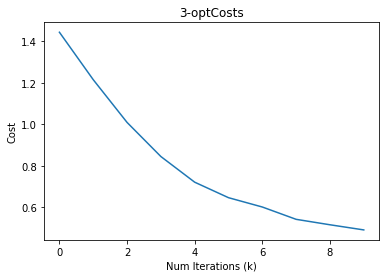

In [69]:
three_opt(stations[:20], lim=10)

### Christofides-Serdyukov algorithm

The Christofides-Serdyukov algorithm works as follows: first, a minimum spanning tree is created. Then, we take the set of vertices with odd degree, which we'll call O. The number of elements in O will always be even. We then find the minimum-weight perfect matching, which we'll call M, in the induced subgraph constructed from O. Then, we combine the edges of M with the edges from the minimum spanning tree, creating a connected multigraph (for which every vertex will have even degree). We then form an Eulerian circuit in that multigraph, and then turn that circuit into a Hamiltonian circuit by skipping any vertices that are repeated.

This algorithm has O(N^2 log n) runtime, which is relatively efficient, and it is guaranteed to produce a solution that is at most 1.5x the length of the optimal solution, making it a very powerful travelling salesman approximation algorithm.

The following code is from here: https://github.com/Retsediv/ChristofidesAlgorithm/blob/99ad2eb37451f5ebd274a497dd823a0b427599fe/christofides.py

In [94]:
def christofides(stations, start_ind = -1):
    # build a graph
    G = build_graph(stations)
#     print("Graph: ", G)

    # build a minimum spanning tree
    MSTree = minimum_spanning_tree(G)
#     print("MSTree: ", MSTree)

    # find odd vertexes
    odd_vertexes = find_odd_vertexes(MSTree)
#     print("Odd vertexes in MSTree: ", odd_vertexes)

    # add minimum weight matching edges to MST
    minimum_weight_matching(MSTree, G, odd_vertexes)
#     print("Minimum weight matching: ", MSTree)

    # find an eulerian tour
    eulerian_tour = find_eulerian_tour(MSTree, G)

#     print("Eulerian tour: ", eulerian_tour)
    
    if start_ind < 0:
        current = eulerian_tour[0]
    else:
        current = eulerian_tour[np.random.randint(len(eulerian_tour))]
    path = [current]
    visited = [False] * len(eulerian_tour)
    visited[0] = True

    length = 0

    for v in eulerian_tour[1:]:
        if not visited[v]:
            path.append(v)
            visited[v] = True

            length += G[current][v]
            current = v

    path.append(path[0])

#     print("Result path: ", path)
#     print("Result length of the path: ", length)
    
    path_stations = []
    for ind in path:
        path_stations.append(stations[ind])
    
    return path_stations, length


def get_length(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** (1.0 / 2.0)


def build_graph(stations):
    graph = {}
    for i in range(len(stations)):
        for j in range(len(stations)):
            if i != j:
                if i not in graph:
                    graph[i] = {}
                graph[i][j] = get_edge_cost(stations[i], stations[j])
    return graph


class UnionFind:
    def __init__(self):
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root

    def __iter__(self):
        return iter(self.parents)

    def union(self, *objects):
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r], r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest


def minimum_spanning_tree(G):
    tree = []
    subtrees = UnionFind()
    for W, u, v in sorted((G[u][v], u, v) for u in G for v in G[u]):
        if subtrees[u] != subtrees[v]:
            tree.append((u, v, W))
            subtrees.union(u, v)

    return tree


def find_odd_vertexes(MST):
    tmp_g = {}
    vertexes = []
    for edge in MST:
        if edge[0] not in tmp_g:
            tmp_g[edge[0]] = 0

        if edge[1] not in tmp_g:
            tmp_g[edge[1]] = 0

        tmp_g[edge[0]] += 1
        tmp_g[edge[1]] += 1

    for vertex in tmp_g:
        if tmp_g[vertex] % 2 == 1:
            vertexes.append(vertex)

    return vertexes


def minimum_weight_matching(MST, G, odd_vert):
    import random
    random.shuffle(odd_vert)

    while odd_vert:
        v = odd_vert.pop()
        length = float("inf")
        u = 1
        closest = 0
        for u in odd_vert:
            if v != u and G[v][u] < length:
                length = G[v][u]
                closest = u

        MST.append((v, closest, length))
        odd_vert.remove(closest)


def find_eulerian_tour(MatchedMSTree, G):
    # find neigbours
    neighbours = {}
    for edge in MatchedMSTree:
        if edge[0] not in neighbours:
            neighbours[edge[0]] = []

        if edge[1] not in neighbours:
            neighbours[edge[1]] = []

        neighbours[edge[0]].append(edge[1])
        neighbours[edge[1]].append(edge[0])

    # print("Neighbours: ", neighbours)

    # finds the hamiltonian circuit
    start_vertex = MatchedMSTree[0][0]
    EP = [neighbours[start_vertex][0]]

    while len(MatchedMSTree) > 0:
        for i, v in enumerate(EP):
            if len(neighbours[v]) > 0:
                break

        while len(neighbours[v]) > 0:
            w = neighbours[v][0]

            remove_edge_from_matchedMST(MatchedMSTree, v, w)

            del neighbours[v][(neighbours[v].index(w))]
            del neighbours[w][(neighbours[w].index(v))]

            i += 1
            EP.insert(i, w)

            v = w

    return EP


def remove_edge_from_matchedMST(MatchedMST, v1, v2):

    for i, item in enumerate(MatchedMST):
        if (item[0] == v2 and item[1] == v1) or (item[0] == v1 and item[1] == v2):
            del MatchedMST[i]

    return MatchedMST





# edges = [[1380, 939], [2848, 96], [3510, 1671], [457, 334], [3888, 666], [984, 965], [2721, 1482], [1286, 525],
#              [2716, 1432], [738, 1325], [1251, 1832], [2728, 1698], [3815, 169], [3683, 1533], [1247, 1945], [123, 862],
#              [1234, 1946], [252, 1240], [611, 673], [2576, 1676], [928, 1700], [53, 857], [1807, 1711], [274, 1420],
#              [2574, 946], [178, 24], [2678, 1825], [1795, 962], [3384, 1498], [3520, 1079], [1256, 61], [1424, 1728],
#              [3913, 192], [3085, 1528], [2573, 1969], [463, 1670], [3875, 598], [298, 1513], [3479, 821], [2542, 236],
#              [3955, 1743], [1323, 280], [3447, 1830], [2936, 337], [1621, 1830], [3373, 1646], [1393, 1368],
#              [3874, 1318], [938, 955], [3022, 474], [2482, 1183], [3854, 923], [376, 825], [2519, 135], [2945, 1622],
#              [953, 268], [2628, 1479], [2097, 981], [890, 1846], [2139, 1806], [2421, 1007], [2290, 1810], [1115, 1052],
#              [2588, 302], [327, 265], [241, 341], [1917, 687], [2991, 792], [2573, 599], [19, 674], [3911, 1673],
#              [872, 1559], [2863, 558], [929, 1766], [839, 620], [3893, 102], [2178, 1619], [3822, 899], [378, 1048],
#              [1178, 100], [2599, 901], [3416, 143], [2961, 1605], [611, 1384], [3113, 885], [2597, 1830], [2586, 1286],
#              [161, 906], [1429, 134], [742, 1025], [1625, 1651], [1187, 706], [1787, 1009], [22, 987], [3640, 43],
#              [3756, 882], [776, 392], [1724, 1642], [198, 1810], [3950, 1558]]

chri_path, chri_cost = christofides(stations, 100)

# tsp([[1, 1], [2, 5], [8, 0]])

#
# tsp([
#     [0, 0],
#     [3, 0],
#     [6, 0],
#
#     [0, 3],
#     [3, 3],
#     [6, 3],
#
#     [0, 6],
#     [3, 6],
#     [6, 6],
#
# ])


In [51]:
len(chri_path)

1489

In [54]:
chri_cost

5.09039357259108

In [ ]:
def test_const_imp(const_algs, imp_algs, num_iter=10, iter_lim=1e4):
    const_algs = [nearest_neighbor, farthest_first, christofides]
    imp_algs = [sim_annealing, two_opt]
    fig, axes = plt.subplots(3,3)
    for i in range(3):
        imp_alg = imp_algs[i]
        for j in range(-1, 2):
            if j >= 0:
                const_alg = const_algs[j]
                alg_title = const_alg.__name__
                const_res_path, _ = const_alg(stations)
            else:
                const_alg = None
                alg_title = ""
                const_res_path = stations
            _, imp_path, cost_list = imp_alg(const_res_path, lim=iter_lim)
            axes[j + 1][i].plot(cost_list)
            axes[j + 1][i].ylabel('Cost')
            axes[j + 1][i].xlabel('Num Iterations (k)')
            axes[j + 1][i].title(alg_title + ' Costs')
    plt.show()

 16%|█▋        | 245/1487 [00:00<00:01, 1200.00it/s]

finished in 100 iterations


  7%|▋         | 107/1487 [00:00<00:01, 1058.17it/s]

finished in 100 iterations


100%|██████████| 1487/1487 [00:03<00:00, 487.05it/s]


finished in 100 iterations
finished in 100 iterations


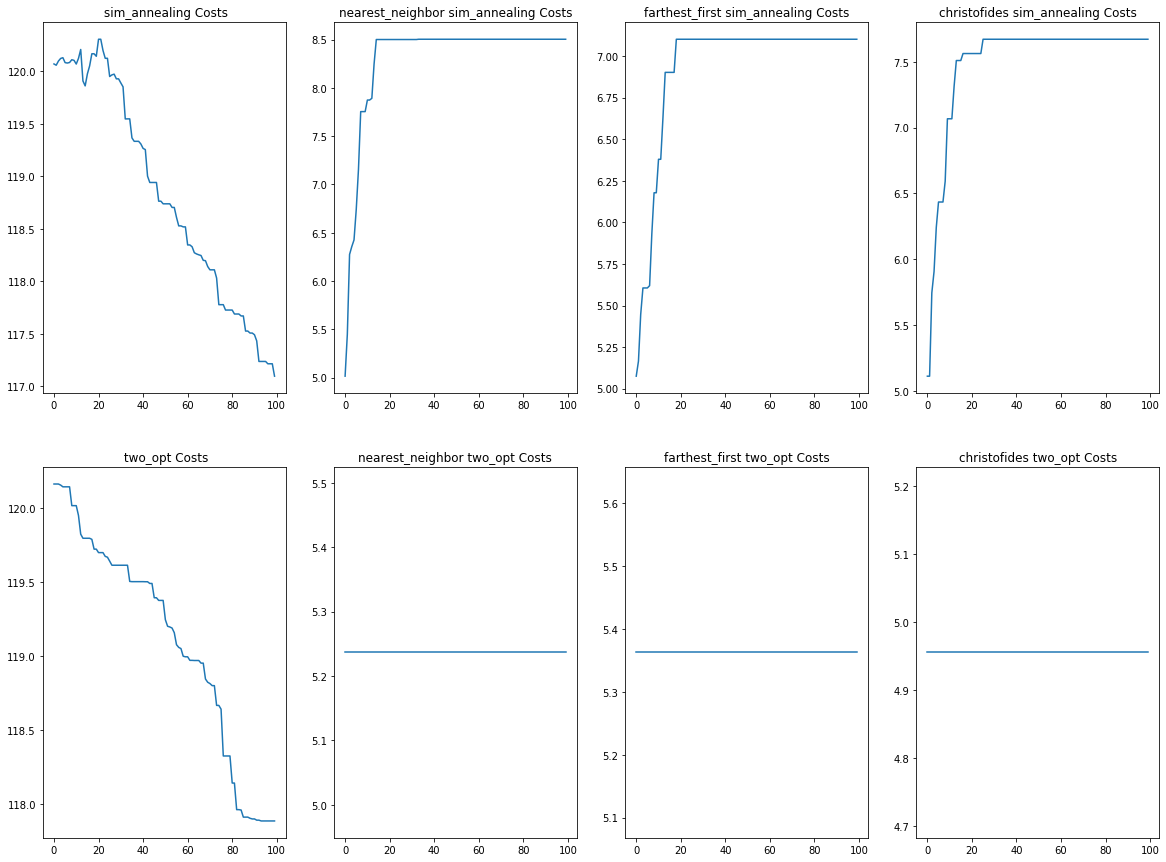

In [96]:
const_algs = [nearest_neighbor, farthest_first, christofides]
imp_algs = [sim_annealing, two_opt]
fig, axes = plt.subplots(2,4)
fig.set_size_inches(20, 15)
for i in range(2):
    imp_alg = imp_algs[i]
    for j in range(-1, 3):
        if j >= 0:
            const_alg = const_algs[j]
            alg_title = const_alg.__name__
            const_res_path, _ = const_alg(stations)
            if const_alg.__name__ == "christofides":
                const_res_path = const_res_path[:-1]
        else:
            const_alg = None
            alg_title = ""
            const_res_path = stations
        _, imp_path, cost_list = imp_alg(const_res_path, shuffle=False, lim=100)
        alg_title += " " + imp_alg.__name__
        axes[i][j + 1].plot(cost_list)
#         axes[j + 1][i].ylabel('Cost')
#         axes[j + 1][i].xlabel('Num Iterations (k)')
        axes[i][j + 1].set_title(alg_title + ' Costs')
plt.show()

In [77]:
_, path, cost_list = two_opt(chri_path, shuffle=False)

KeyError: 730

In [80]:
len(chri_path)

1489

In [95]:
chri_path[0]

6179.07

In [82]:
chri_path[-1]

1279

In [90]:
max(chri_path)

1487

In [91]:
max(nn_path)

8841.03

In [93]:
station_to_idx

{7141.07: 0,
 5175.08: 1,
 3651.04: 2,
 4965.01: 3,
 5065.12: 4,
 4184.07: 5,
 4386.05: 6,
 4903.09: 7,
 7626.02: 8,
 7713.11: 9,
 4419.03: 10,
 4190.06: 11,
 7202.07: 12,
 7648.16: 13,
 7538.18: 14,
 6526.05: 15,
 6254.06: 16,
 8153.1: 17,
 6197.02: 18,
 5108.01: 19,
 7991.01: 20,
 5406.02: 21,
 8213.01: 22,
 8399.06: 23,
 4971.01: 24,
 8655.02: 25,
 4762.05: 26,
 7962.01: 27,
 8795.03: 28,
 5922.07: 29,
 8089.05: 30,
 4243.01: 31,
 4953.04: 32,
 7432.04: 33,
 4404.1: 34,
 5422.04: 35,
 4798.1: 36,
 6364.1: 37,
 6382.05: 38,
 4947.04: 39,
 4151.01: 40,
 6206.08: 41,
 5955.12: 42,
 5532.01: 43,
 6762.04: 44,
 5114.06: 45,
 7617.07: 46,
 4883.03: 47,
 3579.04: 48,
 4205.06: 49,
 4077.07: 50,
 5329.06: 51,
 5294.04: 52,
 5561.04: 53,
 5335.03: 54,
 8472.06: 55,
 8152.03: 56,
 6170.02: 57,
 5348.02: 58,
 4816.02: 59,
 7790.04: 60,
 6379.03: 61,
 8196.02: 62,
 7144.02: 63,
 6151.03: 64,
 7595.17: 65,
 5515.02: 66,
 5944.01: 67,
 6471.02: 68,
 7504.12: 69,
 7020.09: 70,
 3882.01: 71,
 7868.